# This notebook presents a baseline cnn model trained with and without data augmentation to see the differences



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Jeremynadal33/classify_stanford_dogs/blob/master/final_model.ipynb)

The aim of this notebook is : 
* Present best model 
* Tune its hyper-para
* Save the model 
* Write a function that predicts the breed of a dog given its photo 


The hyper parameter search is done using Skopt


In [1]:
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras import backend as K
import os 
import shutil
import matplotlib.pyplot as plt 
from matplotlib import image
import numpy as np
from sklearn.model_selection import train_test_split

print(tf.__version__)

2.4.1


In [2]:
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  from google.colab import drive
  drive.mount('/content/gdrive',force_remount=True)
  !ls /content/gdrive/My\ Drive/Formation-OC/P5-Stackoverflow
  root_dir = '/content/gdrive/My Drive/Formation-OC/P6-Images/'
  input_dir = root_dir + 'inputs/'
  png_dir = root_dir + 'pngs/'

  baseline_species = os.listdir(input_dir+'baseline_inputs/train')

  model_dir = root_dir +'models/'

  #my script
  !ls gdrive/MyDrive/Formation-OC/P6-Images/
else:
  print('Not running on CoLab')
  #my script
  root_dir = '/Users/jeremynadal/Documents/Formation OC IML/P6/'
  input_dir = root_dir + 'inputs/'
  png_dir = root_dir + 'pngs/'
  model_dir = root_dir +'models/'

Running on CoLab
Mounted at /content/gdrive
function.py  inputs  P5_presentation.pptx  pngs
inputs	models	P6-presentation.pptx  pngs


In [4]:
np.random.seed(42) # To ensure re-usability
baseline_dir = input_dir+'baseline_inputs/'

## Scikit optimize is not natively installed :

In [4]:
pip install h5py scikit-optimize

     |████████████████████████████████| 102kB 9.3MB/s 


In [5]:
pip install git+git://github.com/Hvass-Labs/scikit-optimize.git@dd7433da068b5a2509ef4ea4e5195458393e6555

  Cloning git://github.com/Hvass-Labs/scikit-optimize.git (to revision dd7433da068b5a2509ef4ea4e5195458393e6555) to /tmp/pip-req-build-bfs4se_o
  Running command git clone -q git://github.com/Hvass-Labs/scikit-optimize.git /tmp/pip-req-build-bfs4se_o
  Running command git checkout -q dd7433da068b5a2509ef4ea4e5195458393e6555
  Created wheel for scikit-optimize: filename=scikit_optimize-0.5-py2.py3-none-any.whl size=77763 sha256=62725a58ac41c652bec600fdcaaffd955447cbcb20c63d1eda93488b71dfee90
  Stored in directory: /tmp/pip-ephem-wheel-cache-qi6zxv7k/wheels/e2/8b/7e/2956a87f1fb737a8c3f2ed18788b5e0ecfe4718141988c838f
Successfully built scikit-optimize
  Found existing installation: scikit-optimize 0.8.1
    Uninstalling scikit-optimize-0.8.1:
      Successfully uninstalled scikit-optimize-0.8.1


In [6]:
# Imports for skopt
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Prepare everything for the training
## Build a function to create a model

In [3]:
def create_cnn(input_shape, output_length,
               nb_cnn=3, nb_filters = 64, activation_cnn = 'relu', 
               model_transfert = None, fine_tune = False, 
               nb_FC_layer = 3, nb_FC_neurons = 512, reducing = False, activation_FC = 'relu',
               dropout = False,
               name = 'my_cnn_model'
               ):
  '''Create a CNN based model is model_transfert is None. Else, the model_transfert is used for feature extraction. 
  If reducing is not False, nb_FC_neurons must be multiple of 2**nb_FC_layer '''

  assert input_shape[-1] == 3, 'For the moment only models with rgb input is dealt'
  #for shape in input_shape[:-1] : assert shape % 2**nb_cnn ==  0 , 'Each dimension of input must be a multiple of 2**nb_cnn'
  if reducing : assert nb_FC_neurons % 2**nb_FC_layer == 0 , 'If reducing, nb_FC_neurons must be multiple of 2**nb_FC_layer '

  model = tf.keras.models.Sequential(name=name)
  model.add(tf.keras.layers.InputLayer(input_shape=input_shape, name = 'Input_layer'))
  model.add( tf.keras.layers.experimental.preprocessing.Rescaling(1./255,name='Rescaling_layer') ),

  if model_transfert == None: 
    for cnn in range(nb_cnn):
      model.add(tf.keras.layers.Conv2D( filters = nb_filters, kernel_size = (3,3), padding='same', activation = activation_cnn, name ='Conv2D_'+str(cnn+1) ))
      model.add(tf.keras.layers.MaxPooling2D( pool_size=(2, 2), name ='MaxPool_'+str(cnn+1)))
  else : 
    if not fine_tune :
      model_transfert.trainable = False
    model.add(model_transfert)
  
  model.add(tf.keras.layers.Flatten())

  if reducing : 
    for FC in range(nb_FC_layer):
      model.add(tf.keras.layers.Dense(nb_FC_neurons/2**FC, activation= activation_FC, name='FC_layer_'+str(FC+1)))
      if dropout : 
        model.add(tf.keras.layers.Dropout(dropout, name = 'Dropout_'+str(FC+1)))
  else:
    for FC in range(nb_FC_layer):
      model.add(tf.keras.layers.Dense(nb_FC_neurons, activation= activation_FC, name='FC_layer_'+str(FC+1)))
      if dropout :
        if dropout != 0.0:  
          model.add(tf.keras.layers.Dropout(dropout, name = 'Dropout_'+str(FC+1)))

  model.add(tf.keras.layers.Dense(output_length, activation = 'softmax',name='Output_layer'))

  return model


def get_callbacks(monitor='val_loss',save_name=None,patience=8):
    '''Returns the wanted callbacks to save models and avoid overfitting.
    monitor (str, optional): the monitor to check for the early stopping. Default is 'val_loss'
    save_name (str, optional): if not None, uses modelcheckpoint and saves checkpoints at the save_name. Default is None.
    patience (int, optional): number of epoch to wait for improvment of monitor. Default is 8.'''
    if save_name :
        return [tf.keras.callbacks.ModelCheckpoint(filepath=save_name,
                                                   monitor=monitor, 
                                                   save_best_only=True,
                                                   verbose=0),
                tf.keras.callbacks.EarlyStopping(monitor=monitor, 
                                                 patience=patience,
                                                 restore_best_weights=True)
                ]
    else:
        return [tf.keras.callbacks.EarlyStopping(monitor=monitor, 
                                                 patience=patience,
                                                 restore_best_weights=True)
                ]


## Build two ImageDataGenerator to do the on the fly data augmentation for the training

In [8]:
batch_size = 16
input_shape = (150,150,3)


# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip = True,
                                   fill_mode='nearest')

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator()



train_generator = train_datagen.flow_from_directory(baseline_dir+'train_clahe/',  # this is the target directory
                                                   target_size=input_shape[:-1],  # all images will be resized to 150x150
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   color_mode='rgb',
                                                   seed= 42)  #useless for the no augmentation 

validation_generator = test_datagen.flow_from_directory(baseline_dir+'validation_clahe/',  # this is the target directory
                                                   target_size=input_shape[:-1],  # all images will be resized to 150x150
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   color_mode='rgb',
                                                   seed= 42)  #useless for the no augmentation 


STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

Found 493 images belonging to 4 classes.
Found 126 images belonging to 4 classes.


## Use transfer learning

In [6]:
base_xception = tf.keras.applications.Xception( include_top=False, weights='imagenet', input_shape=input_shape, classes=len(baseline_species) )

model_xception = create_cnn(input_shape=input_shape, output_length=len(baseline_species),
               model_transfert = base_xception, fine_tune = False, 
               nb_FC_layer = 2, nb_FC_neurons = 512, reducing = True, activation_FC = 'relu',
               dropout = False,
               name='my_xception'
               )
model_xception.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "my_xception"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Rescaling_layer (Rescaling)  (None, 150, 150, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
FC_layer_1 (Dense)           (None, 512)               26214912  
_________________________________________________________________
FC_layer_2 (Dense)           (None, 256)               131328    
_________________________________________________________________
Output_layer (Dense)         (None, 4)                 1028      
Total params: 47,208,748
Trainable params: 26,347,268
No

## Create the space of hyper para tuning and a function to automatically create and build the model
* Dropout (between 0 and 0.3)
* Num FC layers (between 1 and 3)
* Optimizers (Adam, SGD, RMSProp)
* Learning rate (between 1e-6 and 1e-1)




In [10]:
dim_learning_rate = Real(low=1e-6, high=1e-2, prior='log-uniform',
                         name='learning_rate')

dim_num_dense_layers = Integer(low=1, high=3, name='num_dense_layers') 

dim_name_optimizer = Categorical(categories=['adam', 'SGD', 'RMSProp'],
                             name='name_optimizer')

dim_dropout = Real(low=0, high=0.3,     
                         name='dropout')


In [11]:
dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_name_optimizer,
              dim_dropout]

default_parameters = [1e-5, 1, 'adam', 0]

In [4]:
def create_model(learning_rate, num_dense_layers,
                 name_optimizer, dropout):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    name_optimizer:   Number of nodes in each dense layer.
    dropout:        Activation function for all layers.
    """

    base = tf.keras.applications.Xception( include_top=False, weights='imagenet', input_shape=input_shape, classes=len(baseline_species) )

    model = create_cnn(input_shape=input_shape, output_length=len(baseline_species),
               model_transfert = base, fine_tune = False, 
               nb_FC_layer = num_dense_layers, nb_FC_neurons = 512, reducing = True, activation_FC = 'relu',
               dropout = dropout/10,
               name='my_xception'
               )
    
    if name_optimizer == 'adam':
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif name_optimizer == 'SGD':
      optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif name_optimizer == 'RMSProp' :
      optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else :
      print('optimizer {} not known, using RMSProp'.format(name_optimizer))
      optimizer =tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [13]:
path_best_model = model_dir+ 'best_model.h5'
best_accuracy = 0.0

In [14]:
#Function taken from https://colab.research.google.com/github/Hvass-Labs/TensorFlow-Tutorials/blob/master/19_Hyper-Parameters.ipynb#scrollTo=RWnqMCXmGE5X
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers,
             name_optimizer, dropout):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """

    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('name_optimizer:', name_optimizer)
    print('dropout:', dropout)
    print()
    
    # Create the neural network with these hyper-parameters.
    model = create_model(learning_rate=learning_rate, 
                         num_dense_layers=num_dense_layers,
                         name_optimizer=name_optimizer, 
                         dropout = dropout)

  
   
    # Use Keras to train the model.
    history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=STEP_SIZE_TRAIN,
                                  validation_data=validation_generator,
                                  validation_steps=STEP_SIZE_VALID,
                                  epochs=25,
                                  callbacks=get_callbacks(patience = 15)
                                  )

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return -accuracy

## Lets do a test run

In [ ]:
fitness(x=default_parameters)

learning rate: 1.0e-05
num_dense_layers: 1
name_optimizer: adam
dropout: 0



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
30/30 [==============================] - 131s 4s/step - loss: 1.4525 - accuracy: 0.3808 - val_loss: 0.4625 - val_accuracy: 0.7946
Epoch 2/25
30/30 [==============================] - 6s 207ms/step - loss: 0.8027 - accuracy: 0.6633 - val_loss: 0.4109 - val_accuracy: 0.8304
Epoch 3/25
30/30 [==============================] - 6s 198ms/step - loss: 0.6830 - accuracy: 0.7123 - val_loss: 0.3384 - val_accuracy: 0.8482
Epoch 4/25
30/30 [==============================] - 6s 198ms/step - loss: 0.7428 - accuracy: 0.6596 - val_loss: 0.4116 - val_accuracy: 0.8214
Epoch 5/25
30/30 [==============================] - 6s 198ms/step - loss: 0.6075 - accuracy: 0.7181 - val_loss: 0.4224 - val_accuracy: 0.7768
Epoch 6/25
30/30 [==============================] - 6s 197ms/step - loss: 0.5341 - accuracy: 0.7850 - val_loss: 0.4871 - val_accuracy: 0.7946
Epoch 7/25
30/30 [==============================] - 6s 197ms/step - loss: 0.5221 - accuracy: 0.7646 - val_loss: 0.4752 - val_accuracy: 0.7857
Epoch 8

-0.7767857313156128

# Lets run the full hyperpara search

In [ ]:
%%time
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=40,
                            x0=default_parameters)

learning rate: 1.0e-05
num_dense_layers: 1
name_optimizer: adam
dropout: 0



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
30/30 [==============================] - 9s 231ms/step - loss: 1.3982 - accuracy: 0.4033 - val_loss: 0.4608 - val_accuracy: 0.8125
Epoch 2/25
30/30 [==============================] - 6s 211ms/step - loss: 0.7281 - accuracy: 0.6717 - val_loss: 0.4585 - val_accuracy: 0.7679
Epoch 3/25
30/30 [==============================] - 6s 197ms/step - loss: 0.6699 - accuracy: 0.7133 - val_loss: 0.4736 - val_accuracy: 0.7589
Epoch 4/25
30/30 [==============================] - 6s 200ms/step - loss: 0.6411 - accuracy: 0.6797 - val_loss: 0.5503 - val_accuracy: 0.6964
Epoch 5/25
30/30 [==============================] - 6s 193ms/step - loss: 0.6206 - accuracy: 0.6951 - val_loss: 0.4616 - val_accuracy: 0.7946
Epoch 6/25
30/30 [==============================] - 6s 195ms/step - loss: 0.5096 - accuracy: 0.7979 - val_loss: 0.4387 - val_accuracy: 0.7500
Epoch 7/25
30/30 [==============================] - 6s 196ms/step - loss: 0.5017 - accuracy: 0.7808 - val_loss: 0.4368 - val_accuracy: 0.7768
Epoch 

In [17]:
from copy import deepcopy
from sklearn.utils import check_random_state
from skopt.learning import GaussianProcessRegressor
import warnings

#https://gist.github.com/adidenkov/98f286c5c6b4789f140fa79041f282bb#file-reload-py
def func_new(params):
    global func_, xs_, ys_
    if(len(xs_) > 0):
        y = ys_.pop(0)
        if(params != xs_.pop(0)):
            warnings.warn("Deviated from expected value, re-evaluating", RuntimeWarning)
        else:
            return y
    return func_(params)

def reload_stable(result, addtl_calls, init_seed=None):
    """ Continue an skopt optimization from its returned OptimizeResult object.
        Consistent with uninterrupted optimizations, but will take more time
        feeding in previously queried points.
        PARAMETERS
        ----------
        result [OptimizeResult, scipy object]:
            Result of an skopt optimization, as returned by the optimization method.
            Tested methods:
                dummy_minimize
                forest_minimize
                gbrt_minimize
                gp_minimize
        addtl_calls [int]:
            Number of additional iterations to perform.
        
        init_seed [int, RandomState instance, or None (default)]:
            The value passed as 'random_state' to the original optimization.
        RETURNS
        -------
        result_new [OptimizeResult, scipy object]:
            Updated optimization result returned as an OptimizeResult object. 
    """
    args = deepcopy(result.specs['args'])
    args['n_calls'] += addtl_calls
    
    # global b/c I couldn't find a better way to pass
    global func_, xs_, ys_
    func_ = args['func']
    xs_ = list(result.x_iters)
    ys_ = list(result.func_vals)
    args['func'] = func_new
    
    # recover initial random_state
    if(isinstance(args['random_state'], np.random.RandomState)):
        args['random_state'] = check_random_state(init_seed)
        # if gp_minimize
        if(isinstance(result.specs['args']['base_estimator'], GaussianProcessRegressor)):
            args['random_state'].randint(0, np.iinfo(np.int32).max)
    
    # run the optimization
    result_new = gp_minimize(**args)
    
    # change the function back, to reload multiple times
    result_new.specs['args']['func'] = func_
    
    return result_new

In [15]:
import joblib
test = joblib.load(input_dir+'hyper_para_search.bin')

In [ ]:
test = reload_stable(test, 40)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Deviated from expected value, re-evaluating
  # Remove the CWD from sys.path while we load stuff.


learning rate: 1.5e-03
num_dense_layers: 1
name_optimizer: RMSProp
dropout: 0.17905504738394612



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 235s 8s/step - loss: 81.7731 - accuracy: 0.3905 - val_loss: 5.8463 - val_accuracy: 0.5000
Epoch 2/50
30/30 [==============================] - 6s 192ms/step - loss: 6.3264 - accuracy: 0.5486 - val_loss: 4.7388 - val_accuracy: 0.7321
Epoch 3/50
30/30 [==============================] - 6s 190ms/step - loss: 5.8508 - accuracy: 0.5826 - val_loss: 1.0887 - val_accuracy: 0.8214
Epoch 4/50
30/30 [==============================] - 6s 195ms/step - loss: 1.9944 - accuracy: 0.6466 - val_loss: 0.6792 - val_accuracy: 0.7054
Epoch 5/50
30/30 [==============================] - 6s 193ms/step - loss: 1.2959 - accuracy: 0.6377 - val_loss: 0.4905 - val_accuracy: 0.7232
Epoch 6/50
30/30 [==============================] - 6s 190ms/step - loss: 1.1108 - accuracy: 0.6270 - val_loss: 0.3730 - val_accuracy: 0.7321
Epoch 7/50
30/30 [==============================] - 6s 191ms/step - loss: 0.9090 - accuracy: 0.6638 - val_loss: 0.5368 - val_accuracy: 0.7321
Epoch 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Deviated from expected value, re-evaluating
  # Remove the CWD from sys.path while we load stuff.


learning rate: 5.2e-05
num_dense_layers: 1
name_optimizer: SGD
dropout: 0.0



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 231ms/step - loss: 1.5508 - accuracy: 0.3470 - val_loss: 1.3120 - val_accuracy: 0.4286
Epoch 2/50
30/30 [==============================] - 6s 192ms/step - loss: 1.2950 - accuracy: 0.4172 - val_loss: 1.1026 - val_accuracy: 0.4732
Epoch 3/50
30/30 [==============================] - 6s 191ms/step - loss: 1.1724 - accuracy: 0.4768 - val_loss: 0.9753 - val_accuracy: 0.5804
Epoch 4/50
30/30 [==============================] - 6s 191ms/step - loss: 1.0444 - accuracy: 0.5209 - val_loss: 0.8399 - val_accuracy: 0.6964
Epoch 5/50
30/30 [==============================] - 6s 194ms/step - loss: 1.0701 - accuracy: 0.5264 - val_loss: 0.8021 - val_accuracy: 0.6875
Epoch 6/50
30/30 [==============================] - 6s 195ms/step - loss: 0.9896 - accuracy: 0.5549 - val_loss: 0.7339 - val_accuracy: 0.7054
Epoch 7/50
30/30 [==============================] - 6s 196ms/step - loss: 0.9045 - accuracy: 0.5878 - val_loss: 0.6804 - val_accuracy: 0.7321
Epoch 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Deviated from expected value, re-evaluating
  # Remove the CWD from sys.path while we load stuff.


learning rate: 1.0e-02
num_dense_layers: 3
name_optimizer: RMSProp
dropout: 0.0



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 216ms/step - loss: 1145.2717 - accuracy: 0.2843 - val_loss: 1.4760 - val_accuracy: 0.6518
Epoch 2/50
30/30 [==============================] - 6s 189ms/step - loss: 2.8541 - accuracy: 0.4088 - val_loss: 1.0403 - val_accuracy: 0.6250
Epoch 3/50
30/30 [==============================] - 6s 190ms/step - loss: 1.7382 - accuracy: 0.4548 - val_loss: 1.0275 - val_accuracy: 0.7143
Epoch 4/50
30/30 [==============================] - 6s 190ms/step - loss: 1.4678 - accuracy: 0.4285 - val_loss: 0.7553 - val_accuracy: 0.7232
Epoch 5/50
30/30 [==============================] - 6s 192ms/step - loss: 1.3292 - accuracy: 0.4419 - val_loss: 0.5933 - val_accuracy: 0.6875
Epoch 6/50
30/30 [==============================] - 6s 192ms/step - loss: 1.4059 - accuracy: 0.5692 - val_loss: 0.5330 - val_accuracy: 0.7054
Epoch 7/50
30/30 [==============================] - 6s 190ms/step - loss: 1.0000 - accuracy: 0.5853 - val_loss: 0.6255 - val_accuracy: 0.7143
Epo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Deviated from expected value, re-evaluating
  # Remove the CWD from sys.path while we load stuff.


learning rate: 3.3e-04
num_dense_layers: 3
name_optimizer: RMSProp
dropout: 0.3



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 223ms/step - loss: 8.4356 - accuracy: 0.3349 - val_loss: 0.8028 - val_accuracy: 0.7232
Epoch 2/50
30/30 [==============================] - 6s 193ms/step - loss: 1.6495 - accuracy: 0.5029 - val_loss: 0.7984 - val_accuracy: 0.6429
Epoch 3/50
30/30 [==============================] - 6s 189ms/step - loss: 1.0306 - accuracy: 0.5957 - val_loss: 0.7449 - val_accuracy: 0.7054
Epoch 4/50
30/30 [==============================] - 6s 193ms/step - loss: 1.1671 - accuracy: 0.5893 - val_loss: 0.4657 - val_accuracy: 0.7768
Epoch 5/50
30/30 [==============================] - 6s 190ms/step - loss: 0.8484 - accuracy: 0.6443 - val_loss: 0.5385 - val_accuracy: 0.8125
Epoch 6/50
30/30 [==============================] - 6s 194ms/step - loss: 0.8296 - accuracy: 0.6682 - val_loss: 0.4852 - val_accuracy: 0.7768
Epoch 7/50
30/30 [==============================] - 6s 190ms/step - loss: 0.6825 - accuracy: 0.7372 - val_loss: 0.4885 - val_accuracy: 0.7679
Epoch 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Deviated from expected value, re-evaluating
  # Remove the CWD from sys.path while we load stuff.


learning rate: 2.1e-03
num_dense_layers: 3
name_optimizer: adam
dropout: 0.0



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 227ms/step - loss: 20.5832 - accuracy: 0.3247 - val_loss: 0.7542 - val_accuracy: 0.6964
Epoch 2/50
30/30 [==============================] - 6s 196ms/step - loss: 1.5007 - accuracy: 0.6055 - val_loss: 0.5149 - val_accuracy: 0.7500
Epoch 3/50
30/30 [==============================] - 6s 192ms/step - loss: 1.1652 - accuracy: 0.5766 - val_loss: 0.6306 - val_accuracy: 0.7411
Epoch 4/50
30/30 [==============================] - 6s 193ms/step - loss: 0.8581 - accuracy: 0.6452 - val_loss: 0.4399 - val_accuracy: 0.7679
Epoch 5/50
30/30 [==============================] - 6s 191ms/step - loss: 0.7552 - accuracy: 0.6928 - val_loss: 0.5519 - val_accuracy: 0.6964
Epoch 6/50
30/30 [==============================] - 6s 189ms/step - loss: 0.7222 - accuracy: 0.6977 - val_loss: 0.4654 - val_accuracy: 0.7768
Epoch 7/50
30/30 [==============================] - 6s 193ms/step - loss: 0.7051 - accuracy: 0.7319 - val_loss: 0.4437 - val_accuracy: 0.7857
Epoch

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Deviated from expected value, re-evaluating
  # Remove the CWD from sys.path while we load stuff.


learning rate: 2.1e-03
num_dense_layers: 1
name_optimizer: RMSProp
dropout: 0.3



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 221ms/step - loss: 109.5720 - accuracy: 0.4163 - val_loss: 8.3305 - val_accuracy: 0.6786
Epoch 2/50
30/30 [==============================] - 6s 195ms/step - loss: 11.8421 - accuracy: 0.5596 - val_loss: 10.8164 - val_accuracy: 0.7411
Epoch 3/50
30/30 [==============================] - 6s 193ms/step - loss: 6.8420 - accuracy: 0.6350 - val_loss: 1.4307 - val_accuracy: 0.7946
Epoch 4/50
30/30 [==============================] - 6s 190ms/step - loss: 3.0519 - accuracy: 0.6542 - val_loss: 0.7538 - val_accuracy: 0.7768
Epoch 5/50
30/30 [==============================] - 6s 192ms/step - loss: 1.2415 - accuracy: 0.6449 - val_loss: 0.4932 - val_accuracy: 0.7500
Epoch 6/50
30/30 [==============================] - 6s 196ms/step - loss: 1.3231 - accuracy: 0.6313 - val_loss: 0.5651 - val_accuracy: 0.6696
Epoch 7/50
30/30 [==============================] - 6s 195ms/step - loss: 1.1993 - accuracy: 0.6315 - val_loss: 0.8840 - val_accuracy: 0.7411
Ep

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Deviated from expected value, re-evaluating
  # Remove the CWD from sys.path while we load stuff.


learning rate: 5.1e-05
num_dense_layers: 1
name_optimizer: RMSProp
dropout: 0.0



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 228ms/step - loss: 3.2114 - accuracy: 0.4157 - val_loss: 0.4417 - val_accuracy: 0.8036
Epoch 2/50
30/30 [==============================] - 6s 193ms/step - loss: 0.9192 - accuracy: 0.6236 - val_loss: 0.6000 - val_accuracy: 0.7411
Epoch 3/50
30/30 [==============================] - 6s 190ms/step - loss: 0.9216 - accuracy: 0.6235 - val_loss: 0.4334 - val_accuracy: 0.7857
Epoch 4/50
30/30 [==============================] - 6s 192ms/step - loss: 0.7035 - accuracy: 0.6796 - val_loss: 0.4369 - val_accuracy: 0.7768
Epoch 5/50
30/30 [==============================] - 6s 191ms/step - loss: 0.6635 - accuracy: 0.7062 - val_loss: 0.6761 - val_accuracy: 0.7500
Epoch 6/50
30/30 [==============================] - 6s 192ms/step - loss: 0.6478 - accuracy: 0.7239 - val_loss: 0.5955 - val_accuracy: 0.7589
Epoch 7/50
30/30 [==============================] - 6s 194ms/step - loss: 0.6525 - accuracy: 0.7191 - val_loss: 0.5612 - val_accuracy: 0.7500
Epoch 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Deviated from expected value, re-evaluating
  # Remove the CWD from sys.path while we load stuff.


learning rate: 8.4e-04
num_dense_layers: 3
name_optimizer: SGD
dropout: 0.0



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 222ms/step - loss: 1.2840 - accuracy: 0.3858 - val_loss: 0.7248 - val_accuracy: 0.7232
Epoch 2/50
30/30 [==============================] - 6s 192ms/step - loss: 0.9117 - accuracy: 0.6338 - val_loss: 0.5217 - val_accuracy: 0.7768
Epoch 3/50
30/30 [==============================] - 6s 189ms/step - loss: 0.7936 - accuracy: 0.6386 - val_loss: 0.4723 - val_accuracy: 0.7768
Epoch 4/50
30/30 [==============================] - 6s 188ms/step - loss: 0.6992 - accuracy: 0.7222 - val_loss: 0.4298 - val_accuracy: 0.7768
Epoch 5/50
30/30 [==============================] - 6s 193ms/step - loss: 0.7037 - accuracy: 0.6811 - val_loss: 0.4423 - val_accuracy: 0.7589
Epoch 6/50
30/30 [==============================] - 6s 190ms/step - loss: 0.6375 - accuracy: 0.7398 - val_loss: 0.3856 - val_accuracy: 0.7768
Epoch 7/50
30/30 [==============================] - 6s 191ms/step - loss: 0.5931 - accuracy: 0.7360 - val_loss: 0.3586 - val_accuracy: 0.8125
Epoch 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Deviated from expected value, re-evaluating
  # Remove the CWD from sys.path while we load stuff.


learning rate: 1.7e-04
num_dense_layers: 3
name_optimizer: adam
dropout: 0.0



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 227ms/step - loss: 1.4372 - accuracy: 0.5118 - val_loss: 0.6247 - val_accuracy: 0.7321
Epoch 2/50
30/30 [==============================] - 6s 189ms/step - loss: 0.9442 - accuracy: 0.5628 - val_loss: 0.4112 - val_accuracy: 0.7411
Epoch 3/50
30/30 [==============================] - 6s 193ms/step - loss: 0.7390 - accuracy: 0.6527 - val_loss: 0.4692 - val_accuracy: 0.7500
Epoch 4/50
30/30 [==============================] - 6s 190ms/step - loss: 0.6780 - accuracy: 0.7042 - val_loss: 0.5487 - val_accuracy: 0.7857
Epoch 5/50
30/30 [==============================] - 6s 191ms/step - loss: 0.6963 - accuracy: 0.7281 - val_loss: 0.5673 - val_accuracy: 0.7411
Epoch 6/50
30/30 [==============================] - 6s 192ms/step - loss: 0.6090 - accuracy: 0.7221 - val_loss: 0.4072 - val_accuracy: 0.7857
Epoch 7/50
30/30 [==============================] - 6s 190ms/step - loss: 0.5629 - accuracy: 0.7425 - val_loss: 0.4119 - val_accuracy: 0.8125
Epoch 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Deviated from expected value, re-evaluating
  # Remove the CWD from sys.path while we load stuff.


learning rate: 1.0e-03
num_dense_layers: 1
name_optimizer: SGD
dropout: 0.0



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 229ms/step - loss: 1.4263 - accuracy: 0.4041 - val_loss: 0.5830 - val_accuracy: 0.6875
Epoch 2/50
30/30 [==============================] - 6s 191ms/step - loss: 0.7966 - accuracy: 0.6577 - val_loss: 0.3902 - val_accuracy: 0.8214
Epoch 3/50
30/30 [==============================] - 6s 191ms/step - loss: 0.6683 - accuracy: 0.6944 - val_loss: 0.6022 - val_accuracy: 0.7768
Epoch 4/50
30/30 [==============================] - 6s 190ms/step - loss: 0.7246 - accuracy: 0.6595 - val_loss: 0.4067 - val_accuracy: 0.8125
Epoch 5/50
30/30 [==============================] - 6s 188ms/step - loss: 0.6636 - accuracy: 0.7044 - val_loss: 0.4027 - val_accuracy: 0.7946
Epoch 6/50
30/30 [==============================] - 6s 188ms/step - loss: 0.5786 - accuracy: 0.7277 - val_loss: 0.4825 - val_accuracy: 0.7589
Epoch 7/50
30/30 [==============================] - 6s 191ms/step - loss: 0.5549 - accuracy: 0.7297 - val_loss: 0.4708 - val_accuracy: 0.7321
Epoch 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Deviated from expected value, re-evaluating
  # Remove the CWD from sys.path while we load stuff.


learning rate: 4.8e-05
num_dense_layers: 3
name_optimizer: SGD
dropout: 0.2858378016206821



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 217ms/step - loss: 1.5687 - accuracy: 0.2576 - val_loss: 1.4606 - val_accuracy: 0.3036
Epoch 2/50
30/30 [==============================] - 6s 191ms/step - loss: 1.4482 - accuracy: 0.2758 - val_loss: 1.3350 - val_accuracy: 0.3482
Epoch 3/50
30/30 [==============================] - 6s 191ms/step - loss: 1.3546 - accuracy: 0.3255 - val_loss: 1.2336 - val_accuracy: 0.4196
Epoch 4/50
30/30 [==============================] - 6s 192ms/step - loss: 1.2758 - accuracy: 0.4036 - val_loss: 1.1542 - val_accuracy: 0.4554
Epoch 5/50
30/30 [==============================] - 6s 191ms/step - loss: 1.2275 - accuracy: 0.4190 - val_loss: 1.0852 - val_accuracy: 0.5446
Epoch 6/50
30/30 [==============================] - 6s 190ms/step - loss: 1.1802 - accuracy: 0.5253 - val_loss: 1.0312 - val_accuracy: 0.6071
Epoch 7/50
30/30 [==============================] - 6s 188ms/step - loss: 1.1795 - accuracy: 0.4624 - val_loss: 0.9899 - val_accuracy: 0.6429
Epoch 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Deviated from expected value, re-evaluating
  # Remove the CWD from sys.path while we load stuff.


learning rate: 3.6e-05
num_dense_layers: 3
name_optimizer: RMSProp
dropout: 0.0



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 225ms/step - loss: 1.2369 - accuracy: 0.4836 - val_loss: 0.4364 - val_accuracy: 0.7054
Epoch 2/50
30/30 [==============================] - 6s 192ms/step - loss: 0.7211 - accuracy: 0.6224 - val_loss: 0.4793 - val_accuracy: 0.7054
Epoch 3/50
30/30 [==============================] - 6s 196ms/step - loss: 0.6313 - accuracy: 0.6720 - val_loss: 0.4206 - val_accuracy: 0.7768
Epoch 4/50
30/30 [==============================] - 6s 195ms/step - loss: 0.6121 - accuracy: 0.6952 - val_loss: 0.4114 - val_accuracy: 0.8214
Epoch 5/50
30/30 [==============================] - 6s 192ms/step - loss: 0.6130 - accuracy: 0.6912 - val_loss: 0.3370 - val_accuracy: 0.8304
Epoch 6/50
30/30 [==============================] - 6s 194ms/step - loss: 0.5755 - accuracy: 0.7246 - val_loss: 0.3651 - val_accuracy: 0.7857
Epoch 7/50
30/30 [==============================] - 6s 193ms/step - loss: 0.6055 - accuracy: 0.7109 - val_loss: 0.3977 - val_accuracy: 0.7589
Epoch 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Deviated from expected value, re-evaluating
  # Remove the CWD from sys.path while we load stuff.


learning rate: 1.0e-02
num_dense_layers: 1
name_optimizer: adam
dropout: 0.0



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 229ms/step - loss: 186.0615 - accuracy: 0.4272 - val_loss: 8.8708 - val_accuracy: 0.6696
Epoch 2/50
30/30 [==============================] - 6s 193ms/step - loss: 5.1409 - accuracy: 0.5285 - val_loss: 0.8903 - val_accuracy: 0.6964
Epoch 3/50
30/30 [==============================] - 6s 190ms/step - loss: 0.9369 - accuracy: 0.5856 - val_loss: 0.8633 - val_accuracy: 0.6964
Epoch 4/50
30/30 [==============================] - 6s 191ms/step - loss: 0.8254 - accuracy: 0.6506 - val_loss: 0.6555 - val_accuracy: 0.7054
Epoch 5/50
30/30 [==============================] - 6s 192ms/step - loss: 0.9157 - accuracy: 0.5771 - val_loss: 0.5529 - val_accuracy: 0.7679
Epoch 6/50
30/30 [==============================] - 6s 193ms/step - loss: 0.8848 - accuracy: 0.5979 - val_loss: 0.6273 - val_accuracy: 0.7054
Epoch 7/50
30/30 [==============================] - 6s 192ms/step - loss: 1.2531 - accuracy: 0.5546 - val_loss: 0.7494 - val_accuracy: 0.6518
Epoc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Deviated from expected value, re-evaluating
  # Remove the CWD from sys.path while we load stuff.


learning rate: 3.2e-03
num_dense_layers: 3
name_optimizer: adam
dropout: 0.0



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 232ms/step - loss: 32.7327 - accuracy: 0.3012 - val_loss: 3.1785 - val_accuracy: 0.5982
Epoch 2/50
30/30 [==============================] - 6s 191ms/step - loss: 3.7157 - accuracy: 0.5261 - val_loss: 0.6378 - val_accuracy: 0.7411
Epoch 3/50
30/30 [==============================] - 6s 195ms/step - loss: 1.3398 - accuracy: 0.6182 - val_loss: 0.4926 - val_accuracy: 0.7411
Epoch 4/50
30/30 [==============================] - 6s 192ms/step - loss: 1.0848 - accuracy: 0.6242 - val_loss: 0.4697 - val_accuracy: 0.7946
Epoch 5/50
30/30 [==============================] - 6s 193ms/step - loss: 0.6904 - accuracy: 0.7036 - val_loss: 0.4099 - val_accuracy: 0.8214
Epoch 6/50
30/30 [==============================] - 6s 190ms/step - loss: 0.6658 - accuracy: 0.7031 - val_loss: 0.3823 - val_accuracy: 0.7589
Epoch 7/50
30/30 [==============================] - 6s 190ms/step - loss: 0.6662 - accuracy: 0.6967 - val_loss: 0.5779 - val_accuracy: 0.7411
Epoch

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Deviated from expected value, re-evaluating
  # Remove the CWD from sys.path while we load stuff.


learning rate: 1.0e-02
num_dense_layers: 3
name_optimizer: SGD
dropout: 0.3



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 216ms/step - loss: 1.4920 - accuracy: 0.3773 - val_loss: 0.5114 - val_accuracy: 0.7232
Epoch 2/50
30/30 [==============================] - 6s 191ms/step - loss: 0.8525 - accuracy: 0.6446 - val_loss: 0.4033 - val_accuracy: 0.7946
Epoch 3/50
30/30 [==============================] - 6s 190ms/step - loss: 0.7692 - accuracy: 0.6217 - val_loss: 0.4691 - val_accuracy: 0.7768
Epoch 4/50
30/30 [==============================] - 6s 193ms/step - loss: 0.7000 - accuracy: 0.6561 - val_loss: 0.3727 - val_accuracy: 0.7857
Epoch 5/50
30/30 [==============================] - 6s 191ms/step - loss: 0.6730 - accuracy: 0.6381 - val_loss: 0.3725 - val_accuracy: 0.7679
Epoch 6/50
30/30 [==============================] - 6s 188ms/step - loss: 0.6571 - accuracy: 0.6831 - val_loss: 0.4102 - val_accuracy: 0.7411
Epoch 7/50
30/30 [==============================] - 6s 191ms/step - loss: 0.5732 - accuracy: 0.7177 - val_loss: 0.4500 - val_accuracy: 0.7589
Epoch 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Deviated from expected value, re-evaluating
  # Remove the CWD from sys.path while we load stuff.


learning rate: 1.8e-04
num_dense_layers: 1
name_optimizer: adam
dropout: 0.007196438955750789



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 219ms/step - loss: 3.6202 - accuracy: 0.3946 - val_loss: 0.5535 - val_accuracy: 0.7411
Epoch 2/50
30/30 [==============================] - 6s 190ms/step - loss: 0.8341 - accuracy: 0.6756 - val_loss: 0.5092 - val_accuracy: 0.7857
Epoch 3/50
30/30 [==============================] - 6s 192ms/step - loss: 0.6975 - accuracy: 0.6985 - val_loss: 0.5301 - val_accuracy: 0.7500
Epoch 4/50
30/30 [==============================] - 6s 191ms/step - loss: 0.7823 - accuracy: 0.7006 - val_loss: 0.4138 - val_accuracy: 0.8036
Epoch 5/50
30/30 [==============================] - 6s 189ms/step - loss: 0.5768 - accuracy: 0.7454 - val_loss: 0.4127 - val_accuracy: 0.8036
Epoch 6/50
30/30 [==============================] - 6s 189ms/step - loss: 0.4792 - accuracy: 0.8157 - val_loss: 0.4019 - val_accuracy: 0.8482
Epoch 7/50
30/30 [==============================] - 6s 195ms/step - loss: 0.5659 - accuracy: 0.7788 - val_loss: 0.4208 - val_accuracy: 0.8125
Epoch 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Deviated from expected value, re-evaluating
  # Remove the CWD from sys.path while we load stuff.


learning rate: 1.0e-02
num_dense_layers: 2
name_optimizer: SGD
dropout: 0.0030505588296059253



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 219ms/step - loss: 2.1785 - accuracy: 0.4155 - val_loss: 0.5081 - val_accuracy: 0.6875
Epoch 2/50
30/30 [==============================] - 6s 192ms/step - loss: 0.8106 - accuracy: 0.5843 - val_loss: 0.4850 - val_accuracy: 0.7143
Epoch 3/50
30/30 [==============================] - 6s 192ms/step - loss: 0.7826 - accuracy: 0.6339 - val_loss: 0.4249 - val_accuracy: 0.7321
Epoch 4/50
30/30 [==============================] - 6s 191ms/step - loss: 0.6426 - accuracy: 0.7026 - val_loss: 0.4926 - val_accuracy: 0.7411
Epoch 5/50
30/30 [==============================] - 6s 190ms/step - loss: 0.6088 - accuracy: 0.6712 - val_loss: 0.4194 - val_accuracy: 0.7589
Epoch 6/50
30/30 [==============================] - 6s 190ms/step - loss: 0.5413 - accuracy: 0.7551 - val_loss: 0.4355 - val_accuracy: 0.7411
Epoch 7/50
30/30 [==============================] - 6s 195ms/step - loss: 0.6198 - accuracy: 0.7342 - val_loss: 0.4314 - val_accuracy: 0.7589
Epoch 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Deviated from expected value, re-evaluating
  # Remove the CWD from sys.path while we load stuff.


learning rate: 3.5e-05
num_dense_layers: 1
name_optimizer: adam
dropout: 0.0005688001146344714



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 222ms/step - loss: 1.5412 - accuracy: 0.4513 - val_loss: 0.7629 - val_accuracy: 0.6786
Epoch 2/50
30/30 [==============================] - 6s 200ms/step - loss: 0.9861 - accuracy: 0.6151 - val_loss: 0.5487 - val_accuracy: 0.7321
Epoch 3/50
30/30 [==============================] - 6s 192ms/step - loss: 0.7280 - accuracy: 0.6687 - val_loss: 0.4024 - val_accuracy: 0.7857
Epoch 4/50
30/30 [==============================] - 6s 194ms/step - loss: 0.5837 - accuracy: 0.7018 - val_loss: 0.4130 - val_accuracy: 0.7411
Epoch 5/50
30/30 [==============================] - 6s 195ms/step - loss: 0.5570 - accuracy: 0.7557 - val_loss: 0.3882 - val_accuracy: 0.7679
Epoch 6/50
30/30 [==============================] - 6s 191ms/step - loss: 0.7260 - accuracy: 0.7139 - val_loss: 0.3910 - val_accuracy: 0.7946
Epoch 7/50
30/30 [==============================] - 6s 192ms/step - loss: 0.5402 - accuracy: 0.7316 - val_loss: 0.4921 - val_accuracy: 0.7679
Epoch 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Deviated from expected value, re-evaluating
  # Remove the CWD from sys.path while we load stuff.


learning rate: 2.8e-05
num_dense_layers: 1
name_optimizer: RMSProp
dropout: 0.2955381175502276



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 237ms/step - loss: 2.1713 - accuracy: 0.4318 - val_loss: 0.4551 - val_accuracy: 0.7500
Epoch 2/50
30/30 [==============================] - 7s 224ms/step - loss: 0.9110 - accuracy: 0.6090 - val_loss: 0.4153 - val_accuracy: 0.7768
Epoch 3/50
30/30 [==============================] - 6s 192ms/step - loss: 0.6839 - accuracy: 0.6756 - val_loss: 0.5680 - val_accuracy: 0.7679
Epoch 4/50
30/30 [==============================] - 6s 195ms/step - loss: 0.8254 - accuracy: 0.6559 - val_loss: 0.3966 - val_accuracy: 0.7768
Epoch 5/50
30/30 [==============================] - 6s 193ms/step - loss: 0.7058 - accuracy: 0.6926 - val_loss: 0.4609 - val_accuracy: 0.7679
Epoch 6/50
30/30 [==============================] - 6s 191ms/step - loss: 0.6919 - accuracy: 0.6740 - val_loss: 0.4003 - val_accuracy: 0.7679
Epoch 7/50
30/30 [==============================] - 6s 192ms/step - loss: 0.5631 - accuracy: 0.7456 - val_loss: 0.3913 - val_accuracy: 0.7589
Epoch 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Deviated from expected value, re-evaluating
  # Remove the CWD from sys.path while we load stuff.


learning rate: 9.6e-03
num_dense_layers: 1
name_optimizer: adam
dropout: 0.2927725542208598



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 218ms/step - loss: 258.8180 - accuracy: 0.3669 - val_loss: 7.1273 - val_accuracy: 0.7857
Epoch 2/50
30/30 [==============================] - 6s 197ms/step - loss: 7.2279 - accuracy: 0.5813 - val_loss: 1.2046 - val_accuracy: 0.5893
Epoch 3/50
30/30 [==============================] - 6s 190ms/step - loss: 1.7845 - accuracy: 0.5274 - val_loss: 0.6042 - val_accuracy: 0.7321
Epoch 4/50
30/30 [==============================] - 6s 190ms/step - loss: 0.9043 - accuracy: 0.6348 - val_loss: 0.5585 - val_accuracy: 0.7679
Epoch 5/50
30/30 [==============================] - 6s 191ms/step - loss: 0.9156 - accuracy: 0.6207 - val_loss: 0.4067 - val_accuracy: 0.7768
Epoch 6/50
30/30 [==============================] - 6s 193ms/step - loss: 0.7524 - accuracy: 0.6610 - val_loss: 0.5421 - val_accuracy: 0.7500
Epoch 7/50
30/30 [==============================] - 6s 191ms/step - loss: 1.0582 - accuracy: 0.6353 - val_loss: 0.4859 - val_accuracy: 0.7143
Epoc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Deviated from expected value, re-evaluating
  # Remove the CWD from sys.path while we load stuff.


learning rate: 3.3e-05
num_dense_layers: 2
name_optimizer: adam
dropout: 0.0025890930056842957



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 215ms/step - loss: 1.2613 - accuracy: 0.4135 - val_loss: 0.4722 - val_accuracy: 0.7143
Epoch 2/50
30/30 [==============================] - 6s 195ms/step - loss: 0.7252 - accuracy: 0.6363 - val_loss: 0.3776 - val_accuracy: 0.8036
Epoch 3/50
30/30 [==============================] - 6s 190ms/step - loss: 0.7385 - accuracy: 0.6834 - val_loss: 0.4029 - val_accuracy: 0.7946
Epoch 4/50
30/30 [==============================] - 6s 188ms/step - loss: 0.6434 - accuracy: 0.7127 - val_loss: 0.3824 - val_accuracy: 0.7768
Epoch 5/50
30/30 [==============================] - 6s 190ms/step - loss: 0.5688 - accuracy: 0.7917 - val_loss: 0.3796 - val_accuracy: 0.8036
Epoch 6/50
30/30 [==============================] - 6s 195ms/step - loss: 0.5537 - accuracy: 0.7716 - val_loss: 0.4107 - val_accuracy: 0.7857
Epoch 7/50
30/30 [==============================] - 6s 192ms/step - loss: 0.5086 - accuracy: 0.7837 - val_loss: 0.4515 - val_accuracy: 0.7679
Epoch 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Deviated from expected value, re-evaluating
  # Remove the CWD from sys.path while we load stuff.


learning rate: 3.0e-04
num_dense_layers: 2
name_optimizer: adam
dropout: 0.000431569105436136



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 219ms/step - loss: 3.9499 - accuracy: 0.4059 - val_loss: 1.6865 - val_accuracy: 0.7143
Epoch 2/50
30/30 [==============================] - 6s 189ms/step - loss: 1.0362 - accuracy: 0.6582 - val_loss: 0.7901 - val_accuracy: 0.7500
Epoch 3/50
30/30 [==============================] - 6s 188ms/step - loss: 0.8599 - accuracy: 0.6705 - val_loss: 0.5172 - val_accuracy: 0.7411
Epoch 4/50
30/30 [==============================] - 6s 188ms/step - loss: 0.7668 - accuracy: 0.6763 - val_loss: 0.4550 - val_accuracy: 0.7857
Epoch 5/50
30/30 [==============================] - 6s 188ms/step - loss: 0.7014 - accuracy: 0.6773 - val_loss: 0.7777 - val_accuracy: 0.6518
Epoch 6/50
30/30 [==============================] - 6s 187ms/step - loss: 0.8440 - accuracy: 0.6012 - val_loss: 0.5202 - val_accuracy: 0.7589
Epoch 7/50
30/30 [==============================] - 6s 193ms/step - loss: 0.6755 - accuracy: 0.6962 - val_loss: 0.5055 - val_accuracy: 0.7411
Epoch 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Deviated from expected value, re-evaluating
  # Remove the CWD from sys.path while we load stuff.


learning rate: 9.9e-03
num_dense_layers: 1
name_optimizer: adam
dropout: 0.2990008367241758



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 220ms/step - loss: 203.6822 - accuracy: 0.3764 - val_loss: 15.1160 - val_accuracy: 0.7411
Epoch 2/50
30/30 [==============================] - 6s 190ms/step - loss: 6.7902 - accuracy: 0.5243 - val_loss: 1.0547 - val_accuracy: 0.6339
Epoch 3/50
30/30 [==============================] - 6s 191ms/step - loss: 1.2784 - accuracy: 0.4869 - val_loss: 0.3515 - val_accuracy: 0.7589
Epoch 4/50
30/30 [==============================] - 6s 191ms/step - loss: 0.8888 - accuracy: 0.5789 - val_loss: 0.6243 - val_accuracy: 0.7232
Epoch 5/50
30/30 [==============================] - 6s 189ms/step - loss: 1.2843 - accuracy: 0.5645 - val_loss: 0.4771 - val_accuracy: 0.7500
Epoch 6/50
30/30 [==============================] - 6s 189ms/step - loss: 0.9148 - accuracy: 0.5702 - val_loss: 0.4129 - val_accuracy: 0.7232
Epoch 7/50
30/30 [==============================] - 6s 189ms/step - loss: 0.9884 - accuracy: 0.5782 - val_loss: 0.4443 - val_accuracy: 0.7768
Epo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Deviated from expected value, re-evaluating
  # Remove the CWD from sys.path while we load stuff.


learning rate: 1.5e-04
num_dense_layers: 3
name_optimizer: SGD
dropout: 0.0014404672300458612



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 226ms/step - loss: 1.3899 - accuracy: 0.3258 - val_loss: 1.2397 - val_accuracy: 0.5714
Epoch 2/50
30/30 [==============================] - 6s 186ms/step - loss: 1.2749 - accuracy: 0.4383 - val_loss: 1.0863 - val_accuracy: 0.6250
Epoch 3/50
30/30 [==============================] - 6s 189ms/step - loss: 1.1985 - accuracy: 0.4671 - val_loss: 0.9775 - val_accuracy: 0.6786
Epoch 4/50
30/30 [==============================] - 6s 187ms/step - loss: 1.1424 - accuracy: 0.4870 - val_loss: 0.8730 - val_accuracy: 0.7054
Epoch 5/50
30/30 [==============================] - 6s 187ms/step - loss: 1.0579 - accuracy: 0.5077 - val_loss: 0.7886 - val_accuracy: 0.7589
Epoch 6/50
30/30 [==============================] - 6s 190ms/step - loss: 0.9843 - accuracy: 0.6314 - val_loss: 0.7305 - val_accuracy: 0.7679
Epoch 7/50
30/30 [==============================] - 6s 189ms/step - loss: 0.9053 - accuracy: 0.5867 - val_loss: 0.6576 - val_accuracy: 0.7946
Epoch 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Deviated from expected value, re-evaluating
  # Remove the CWD from sys.path while we load stuff.


learning rate: 4.9e-04
num_dense_layers: 1
name_optimizer: RMSProp
dropout: 0.0010444435076902515



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 225ms/step - loss: 27.7987 - accuracy: 0.4009 - val_loss: 7.8603 - val_accuracy: 0.5893
Epoch 2/50
30/30 [==============================] - 6s 191ms/step - loss: 4.7485 - accuracy: 0.5552 - val_loss: 2.1806 - val_accuracy: 0.7054
Epoch 3/50
30/30 [==============================] - 6s 194ms/step - loss: 2.5811 - accuracy: 0.6385 - val_loss: 1.4520 - val_accuracy: 0.7143
Epoch 4/50
30/30 [==============================] - 6s 194ms/step - loss: 2.4003 - accuracy: 0.7023 - val_loss: 1.9521 - val_accuracy: 0.7768
Epoch 5/50
30/30 [==============================] - 6s 197ms/step - loss: 2.6804 - accuracy: 0.6387 - val_loss: 3.1338 - val_accuracy: 0.7232
Epoch 6/50
30/30 [==============================] - 6s 188ms/step - loss: 1.7407 - accuracy: 0.7121 - val_loss: 0.7094 - val_accuracy: 0.7768
Epoch 7/50
30/30 [==============================] - 6s 193ms/step - loss: 1.3204 - accuracy: 0.6954 - val_loss: 0.7103 - val_accuracy: 0.7589
Epoch

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Deviated from expected value, re-evaluating
  # Remove the CWD from sys.path while we load stuff.


learning rate: 3.5e-03
num_dense_layers: 1
name_optimizer: adam
dropout: 0.0076937751199825394



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 8s 215ms/step - loss: 65.4499 - accuracy: 0.3691 - val_loss: 6.3938 - val_accuracy: 0.7679
Epoch 2/50
30/30 [==============================] - 6s 197ms/step - loss: 6.6939 - accuracy: 0.6301 - val_loss: 1.8972 - val_accuracy: 0.7768
Epoch 3/50
30/30 [==============================] - 6s 189ms/step - loss: 1.8171 - accuracy: 0.6658 - val_loss: 0.6400 - val_accuracy: 0.7857
Epoch 4/50
30/30 [==============================] - 6s 190ms/step - loss: 0.8995 - accuracy: 0.6604 - val_loss: 0.4378 - val_accuracy: 0.7857
Epoch 5/50
30/30 [==============================] - 6s 188ms/step - loss: 0.6687 - accuracy: 0.7005 - val_loss: 0.4425 - val_accuracy: 0.7768
Epoch 6/50
30/30 [==============================] - 6s 187ms/step - loss: 0.7233 - accuracy: 0.6966 - val_loss: 0.4597 - val_accuracy: 0.7857
Epoch 7/50
30/30 [==============================] - 6s 189ms/step - loss: 0.7104 - accuracy: 0.7380 - val_loss: 0.4138 - val_accuracy: 0.7857
Epoch

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Deviated from expected value, re-evaluating
  # Remove the CWD from sys.path while we load stuff.


learning rate: 1.0e-04
num_dense_layers: 1
name_optimizer: adam
dropout: 0.0031678987282382615



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 213ms/step - loss: 2.7248 - accuracy: 0.4242 - val_loss: 0.5761 - val_accuracy: 0.7321
Epoch 2/50
30/30 [==============================] - 6s 188ms/step - loss: 0.8463 - accuracy: 0.6154 - val_loss: 0.4133 - val_accuracy: 0.7768
Epoch 3/50
30/30 [==============================] - 6s 188ms/step - loss: 0.6295 - accuracy: 0.6824 - val_loss: 0.4835 - val_accuracy: 0.7500
Epoch 4/50
30/30 [==============================] - 6s 192ms/step - loss: 0.6607 - accuracy: 0.7065 - val_loss: 0.4567 - val_accuracy: 0.7679
Epoch 5/50
30/30 [==============================] - 6s 191ms/step - loss: 0.5332 - accuracy: 0.7442 - val_loss: 0.4429 - val_accuracy: 0.8036
Epoch 6/50
30/30 [==============================] - 6s 188ms/step - loss: 0.5492 - accuracy: 0.7468 - val_loss: 0.4667 - val_accuracy: 0.7500
Epoch 7/50
30/30 [==============================] - 6s 190ms/step - loss: 0.5695 - accuracy: 0.7563 - val_loss: 0.3189 - val_accuracy: 0.8482
Epoch 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Deviated from expected value, re-evaluating
  # Remove the CWD from sys.path while we load stuff.


learning rate: 2.7e-03
num_dense_layers: 3
name_optimizer: adam
dropout: 0.2946173692300751



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 216ms/step - loss: 20.4402 - accuracy: 0.4104 - val_loss: 0.8951 - val_accuracy: 0.7679
Epoch 2/50
30/30 [==============================] - 6s 190ms/step - loss: 2.8147 - accuracy: 0.5871 - val_loss: 0.6547 - val_accuracy: 0.7589
Epoch 3/50
30/30 [==============================] - 6s 187ms/step - loss: 1.1008 - accuracy: 0.6761 - val_loss: 0.9386 - val_accuracy: 0.7054
Epoch 4/50
30/30 [==============================] - 6s 188ms/step - loss: 1.0338 - accuracy: 0.6489 - val_loss: 0.4697 - val_accuracy: 0.7946
Epoch 5/50
30/30 [==============================] - 6s 189ms/step - loss: 0.7758 - accuracy: 0.6856 - val_loss: 0.4902 - val_accuracy: 0.7321
Epoch 6/50
30/30 [==============================] - 6s 190ms/step - loss: 0.7152 - accuracy: 0.6875 - val_loss: 0.5167 - val_accuracy: 0.6964
Epoch 7/50
30/30 [==============================] - 6s 192ms/step - loss: 0.8066 - accuracy: 0.6790 - val_loss: 0.6103 - val_accuracy: 0.7500
Epoch

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Deviated from expected value, re-evaluating
  # Remove the CWD from sys.path while we load stuff.


learning rate: 5.5e-05
num_dense_layers: 3
name_optimizer: adam
dropout: 0.0020032837495556847



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 221ms/step - loss: 1.1733 - accuracy: 0.4888 - val_loss: 0.4099 - val_accuracy: 0.7946
Epoch 2/50
30/30 [==============================] - 6s 190ms/step - loss: 0.7614 - accuracy: 0.6231 - val_loss: 0.3682 - val_accuracy: 0.7679
Epoch 3/50
30/30 [==============================] - 6s 191ms/step - loss: 0.6606 - accuracy: 0.7222 - val_loss: 0.3856 - val_accuracy: 0.7768
Epoch 4/50
30/30 [==============================] - 6s 187ms/step - loss: 0.6265 - accuracy: 0.7326 - val_loss: 0.7441 - val_accuracy: 0.7232
Epoch 5/50
30/30 [==============================] - 6s 189ms/step - loss: 0.6043 - accuracy: 0.7314 - val_loss: 0.4082 - val_accuracy: 0.7679
Epoch 6/50
30/30 [==============================] - 6s 187ms/step - loss: 0.5089 - accuracy: 0.7865 - val_loss: 0.4032 - val_accuracy: 0.7589
Epoch 7/50
30/30 [==============================] - 6s 188ms/step - loss: 0.6463 - accuracy: 0.7249 - val_loss: 0.4217 - val_accuracy: 0.7589
Epoch 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Deviated from expected value, re-evaluating
  # Remove the CWD from sys.path while we load stuff.


learning rate: 2.1e-04
num_dense_layers: 1
name_optimizer: adam
dropout: 0.2980291843272703



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 215ms/step - loss: 5.1377 - accuracy: 0.3826 - val_loss: 0.9472 - val_accuracy: 0.7589
Epoch 2/50
30/30 [==============================] - 6s 190ms/step - loss: 1.0412 - accuracy: 0.6453 - val_loss: 0.7197 - val_accuracy: 0.7679
Epoch 3/50
30/30 [==============================] - 6s 195ms/step - loss: 0.8758 - accuracy: 0.6478 - val_loss: 0.4442 - val_accuracy: 0.8125
Epoch 4/50
30/30 [==============================] - 6s 189ms/step - loss: 0.7989 - accuracy: 0.6590 - val_loss: 0.4561 - val_accuracy: 0.7946
Epoch 5/50
30/30 [==============================] - 6s 190ms/step - loss: 0.5686 - accuracy: 0.7268 - val_loss: 0.3253 - val_accuracy: 0.8571
Epoch 6/50
30/30 [==============================] - 6s 190ms/step - loss: 0.5893 - accuracy: 0.7421 - val_loss: 0.4215 - val_accuracy: 0.7857
Epoch 7/50
30/30 [==============================] - 6s 194ms/step - loss: 0.4986 - accuracy: 0.8026 - val_loss: 0.4330 - val_accuracy: 0.7679
Epoch 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 218ms/step - loss: 1.6495 - accuracy: 0.2978 - val_loss: 0.8604 - val_accuracy: 0.6339
Epoch 2/50
30/30 [==============================] - 6s 191ms/step - loss: 1.0474 - accuracy: 0.5876 - val_loss: 0.6832 - val_accuracy: 0.6964
Epoch 3/50
30/30 [==============================] - 6s 188ms/step - loss: 0.8892 - accuracy: 0.5710 - val_loss: 0.5849 - val_accuracy: 0.7143
Epoch 4/50
30/30 [==============================] - 6s 191ms/step - loss: 0.8096 - accuracy: 0.6299 - val_loss: 0.5676 - val_accuracy: 0.6964
Epoch 5/50
30/30 [==============================] - 6s 189ms/step - loss: 0.7991 - accuracy: 0.6313 - val_loss: 0.4881 - val_accuracy: 0.7589
Epoch 6/50
30/30 [==============================] - 6s 197ms/step - loss: 0.7714 - accuracy: 0.6458 - val_loss: 0.4685 - val_accuracy: 0.7589
Epoch 7/50
30/30 [==============================] - 6s 192ms/step - loss: 0.7006 - accuracy: 0.6894 - val_loss: 0.4333 - val_accuracy: 0.7500
Epoch 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 224ms/step - loss: 7.4708 - accuracy: 0.4898 - val_loss: 2.1600 - val_accuracy: 0.6964
Epoch 2/50
30/30 [==============================] - 6s 191ms/step - loss: 2.8105 - accuracy: 0.6135 - val_loss: 1.1003 - val_accuracy: 0.7411
Epoch 3/50
30/30 [==============================] - 6s 189ms/step - loss: 1.6800 - accuracy: 0.6783 - val_loss: 1.9778 - val_accuracy: 0.7143
Epoch 4/50
30/30 [==============================] - 6s 192ms/step - loss: 1.9522 - accuracy: 0.6321 - val_loss: 1.3192 - val_accuracy: 0.7500
Epoch 5/50
30/30 [==============================] - 6s 189ms/step - loss: 1.1066 - accuracy: 0.7180 - val_loss: 0.8020 - val_accuracy: 0.7500
Epoch 6/50
30/30 [==============================] - 6s 192ms/step - loss: 0.9610 - accuracy: 0.6926 - val_loss: 0.7165 - val_accuracy: 0.7857
Epoch 7/50
30/30 [==============================] - 6s 188ms/step - loss: 0.7553 - accuracy: 0.7404 - val_loss: 0.7740 - val_accuracy: 0.7768
Epoch 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 216ms/step - loss: 1.5851 - accuracy: 0.4296 - val_loss: 0.4948 - val_accuracy: 0.7411
Epoch 2/50
30/30 [==============================] - 6s 185ms/step - loss: 0.8309 - accuracy: 0.6287 - val_loss: 0.4288 - val_accuracy: 0.7857
Epoch 3/50
30/30 [==============================] - 6s 187ms/step - loss: 0.6402 - accuracy: 0.7120 - val_loss: 0.4241 - val_accuracy: 0.7679
Epoch 4/50
30/30 [==============================] - 6s 191ms/step - loss: 0.6523 - accuracy: 0.7177 - val_loss: 0.4547 - val_accuracy: 0.7679
Epoch 5/50
30/30 [==============================] - 6s 189ms/step - loss: 0.6465 - accuracy: 0.7270 - val_loss: 0.3940 - val_accuracy: 0.7946
Epoch 6/50
30/30 [==============================] - 6s 188ms/step - loss: 0.5859 - accuracy: 0.7404 - val_loss: 0.4083 - val_accuracy: 0.7946
Epoch 7/50
30/30 [==============================] - 6s 189ms/step - loss: 0.5230 - accuracy: 0.7934 - val_loss: 0.4512 - val_accuracy: 0.7857
Epoch 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 219ms/step - loss: 685.0430 - accuracy: 0.3934 - val_loss: 3.7592 - val_accuracy: 0.7500
Epoch 2/50
30/30 [==============================] - 6s 189ms/step - loss: 13.8679 - accuracy: 0.5438 - val_loss: 4.2516 - val_accuracy: 0.7143
Epoch 3/50
30/30 [==============================] - 6s 189ms/step - loss: 6.1678 - accuracy: 0.5247 - val_loss: 5.7335 - val_accuracy: 0.5536
Epoch 4/50
30/30 [==============================] - 6s 194ms/step - loss: 1.9944 - accuracy: 0.5667 - val_loss: 3.6889 - val_accuracy: 0.6964
Epoch 5/50
30/30 [==============================] - 6s 187ms/step - loss: 9.7690 - accuracy: 0.5098 - val_loss: 1.2901 - val_accuracy: 0.7143
Epoch 6/50
30/30 [==============================] - 6s 196ms/step - loss: 1.7496 - accuracy: 0.5838 - val_loss: 1.5232 - val_accuracy: 0.6696
Epoch 7/50
30/30 [==============================] - 6s 189ms/step - loss: 3.1477 - accuracy: 0.5930 - val_loss: 1.8643 - val_accuracy: 0.6518
Epo

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 224ms/step - loss: 22.1335 - accuracy: 0.3982 - val_loss: 1.7380 - val_accuracy: 0.7321
Epoch 2/50
30/30 [==============================] - 6s 187ms/step - loss: 2.1493 - accuracy: 0.6381 - val_loss: 1.6594 - val_accuracy: 0.7589
Epoch 3/50
30/30 [==============================] - 6s 188ms/step - loss: 1.5990 - accuracy: 0.6047 - val_loss: 0.6603 - val_accuracy: 0.7857
Epoch 4/50
30/30 [==============================] - 6s 188ms/step - loss: 0.8497 - accuracy: 0.7321 - val_loss: 0.5227 - val_accuracy: 0.6964
Epoch 5/50
30/30 [==============================] - 6s 190ms/step - loss: 0.6186 - accuracy: 0.7165 - val_loss: 0.3848 - val_accuracy: 0.7679
Epoch 6/50
30/30 [==============================] - 6s 194ms/step - loss: 0.6352 - accuracy: 0.6907 - val_loss: 0.3851 - val_accuracy: 0.7321
Epoch 7/50
30/30 [==============================] - 6s 186ms/step - loss: 0.6533 - accuracy: 0.7224 - val_loss: 0.4221 - val_accuracy: 0.7768
Epoch

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 216ms/step - loss: 4.8043 - accuracy: 0.4440 - val_loss: 2.2955 - val_accuracy: 0.7321
Epoch 2/50
30/30 [==============================] - 6s 190ms/step - loss: 2.1564 - accuracy: 0.6355 - val_loss: 0.6921 - val_accuracy: 0.7321
Epoch 3/50
30/30 [==============================] - 6s 196ms/step - loss: 0.9933 - accuracy: 0.6575 - val_loss: 0.4378 - val_accuracy: 0.8125
Epoch 4/50
30/30 [==============================] - 6s 190ms/step - loss: 0.9295 - accuracy: 0.6311 - val_loss: 0.4690 - val_accuracy: 0.8036
Epoch 5/50
30/30 [==============================] - 6s 196ms/step - loss: 0.8348 - accuracy: 0.6524 - val_loss: 0.4241 - val_accuracy: 0.8036
Epoch 6/50
30/30 [==============================] - 6s 194ms/step - loss: 0.7590 - accuracy: 0.6849 - val_loss: 0.4614 - val_accuracy: 0.7411
Epoch 7/50
30/30 [==============================] - 6s 192ms/step - loss: 0.7580 - accuracy: 0.6505 - val_loss: 0.4068 - val_accuracy: 0.7946
Epoch 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 215ms/step - loss: 22.5370 - accuracy: 0.3997 - val_loss: 2.0790 - val_accuracy: 0.7232
Epoch 2/50
30/30 [==============================] - 6s 185ms/step - loss: 1.2131 - accuracy: 0.6912 - val_loss: 0.4756 - val_accuracy: 0.7589
Epoch 3/50
30/30 [==============================] - 6s 188ms/step - loss: 1.3192 - accuracy: 0.6138 - val_loss: 0.4248 - val_accuracy: 0.8036
Epoch 4/50
30/30 [==============================] - 6s 190ms/step - loss: 0.7203 - accuracy: 0.7067 - val_loss: 0.4114 - val_accuracy: 0.7589
Epoch 5/50
30/30 [==============================] - 6s 190ms/step - loss: 0.5503 - accuracy: 0.7486 - val_loss: 0.3803 - val_accuracy: 0.7946
Epoch 6/50
30/30 [==============================] - 6s 187ms/step - loss: 0.5653 - accuracy: 0.7588 - val_loss: 0.4828 - val_accuracy: 0.8036
Epoch 7/50
30/30 [==============================] - 6s 191ms/step - loss: 0.5725 - accuracy: 0.7677 - val_loss: 0.5394 - val_accuracy: 0.7411
Epoch

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 229ms/step - loss: 9.3126 - accuracy: 0.3868 - val_loss: 0.7438 - val_accuracy: 0.8036
Epoch 2/50
30/30 [==============================] - 6s 186ms/step - loss: 2.3067 - accuracy: 0.5984 - val_loss: 0.6138 - val_accuracy: 0.7500
Epoch 3/50
30/30 [==============================] - 6s 188ms/step - loss: 1.2207 - accuracy: 0.6647 - val_loss: 0.8939 - val_accuracy: 0.7143
Epoch 4/50
30/30 [==============================] - 6s 190ms/step - loss: 1.4038 - accuracy: 0.6052 - val_loss: 0.6470 - val_accuracy: 0.7500
Epoch 5/50
30/30 [==============================] - 6s 189ms/step - loss: 0.7262 - accuracy: 0.7278 - val_loss: 0.4976 - val_accuracy: 0.7679
Epoch 6/50
30/30 [==============================] - 6s 192ms/step - loss: 0.5853 - accuracy: 0.7256 - val_loss: 0.5012 - val_accuracy: 0.7411
Epoch 7/50
30/30 [==============================] - 6s 192ms/step - loss: 0.6099 - accuracy: 0.7252 - val_loss: 0.4998 - val_accuracy: 0.7143
Epoch 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 8s 217ms/step - loss: 2.1435 - accuracy: 0.4671 - val_loss: 0.7362 - val_accuracy: 0.7589
Epoch 2/50
30/30 [==============================] - 6s 200ms/step - loss: 0.9543 - accuracy: 0.6488 - val_loss: 0.4088 - val_accuracy: 0.7857
Epoch 3/50
30/30 [==============================] - 6s 187ms/step - loss: 0.6750 - accuracy: 0.7183 - val_loss: 0.4396 - val_accuracy: 0.7768
Epoch 4/50
30/30 [==============================] - 6s 188ms/step - loss: 0.7005 - accuracy: 0.7021 - val_loss: 0.6276 - val_accuracy: 0.7589
Epoch 5/50
30/30 [==============================] - 6s 192ms/step - loss: 0.6759 - accuracy: 0.7324 - val_loss: 0.4848 - val_accuracy: 0.7411
Epoch 6/50
30/30 [==============================] - 6s 188ms/step - loss: 0.5245 - accuracy: 0.7671 - val_loss: 0.4628 - val_accuracy: 0.7232
Epoch 7/50
30/30 [==============================] - 6s 189ms/step - loss: 0.5704 - accuracy: 0.7741 - val_loss: 0.4172 - val_accuracy: 0.7857
Epoch 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 221ms/step - loss: 4.5845 - accuracy: 0.5054 - val_loss: 0.7883 - val_accuracy: 0.7500
Epoch 2/50
30/30 [==============================] - 6s 185ms/step - loss: 1.8639 - accuracy: 0.6253 - val_loss: 0.5812 - val_accuracy: 0.7946
Epoch 3/50
30/30 [==============================] - 6s 190ms/step - loss: 1.1294 - accuracy: 0.6787 - val_loss: 0.7104 - val_accuracy: 0.7679
Epoch 4/50
30/30 [==============================] - 6s 188ms/step - loss: 0.9891 - accuracy: 0.6457 - val_loss: 0.5365 - val_accuracy: 0.7768
Epoch 5/50
30/30 [==============================] - 6s 189ms/step - loss: 0.8234 - accuracy: 0.6991 - val_loss: 0.5863 - val_accuracy: 0.7232
Epoch 6/50
30/30 [==============================] - 6s 190ms/step - loss: 0.6895 - accuracy: 0.7388 - val_loss: 0.6216 - val_accuracy: 0.7500
Epoch 7/50
30/30 [==============================] - 6s 184ms/step - loss: 0.7392 - accuracy: 0.7279 - val_loss: 0.3869 - val_accuracy: 0.7768
Epoch 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 228ms/step - loss: 185.0328 - accuracy: 0.3212 - val_loss: 0.5323 - val_accuracy: 0.7232
Epoch 2/50
30/30 [==============================] - 6s 188ms/step - loss: 0.8743 - accuracy: 0.5571 - val_loss: 0.5123 - val_accuracy: 0.6964
Epoch 3/50
30/30 [==============================] - 6s 190ms/step - loss: 0.8135 - accuracy: 0.5711 - val_loss: 0.5812 - val_accuracy: 0.7143
Epoch 4/50
30/30 [==============================] - 6s 187ms/step - loss: 0.8139 - accuracy: 0.5816 - val_loss: 0.4643 - val_accuracy: 0.7143
Epoch 5/50
30/30 [==============================] - 6s 186ms/step - loss: 0.7323 - accuracy: 0.6360 - val_loss: 0.4747 - val_accuracy: 0.6875
Epoch 6/50
30/30 [==============================] - 6s 192ms/step - loss: 0.8667 - accuracy: 0.6074 - val_loss: 0.4002 - val_accuracy: 0.8125
Epoch 7/50
30/30 [==============================] - 6s 187ms/step - loss: 0.7790 - accuracy: 0.6287 - val_loss: 0.4303 - val_accuracy: 0.7411
Epoc

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 213ms/step - loss: 3.2376 - accuracy: 0.3937 - val_loss: 0.4342 - val_accuracy: 0.7768
Epoch 2/50
30/30 [==============================] - 6s 187ms/step - loss: 0.7536 - accuracy: 0.6364 - val_loss: 0.3891 - val_accuracy: 0.7857
Epoch 3/50
30/30 [==============================] - 6s 186ms/step - loss: 0.6800 - accuracy: 0.6857 - val_loss: 0.3896 - val_accuracy: 0.7857
Epoch 4/50
30/30 [==============================] - 6s 188ms/step - loss: 0.6424 - accuracy: 0.7033 - val_loss: 0.4016 - val_accuracy: 0.7857
Epoch 5/50
30/30 [==============================] - 6s 190ms/step - loss: 0.6187 - accuracy: 0.7213 - val_loss: 0.3647 - val_accuracy: 0.8304
Epoch 6/50
30/30 [==============================] - 6s 191ms/step - loss: 0.5970 - accuracy: 0.7442 - val_loss: 0.3861 - val_accuracy: 0.7768
Epoch 7/50
30/30 [==============================] - 6s 188ms/step - loss: 0.5847 - accuracy: 0.7403 - val_loss: 0.5354 - val_accuracy: 0.7054
Epoch 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 219ms/step - loss: 1.4025 - accuracy: 0.3830 - val_loss: 0.6935 - val_accuracy: 0.7679
Epoch 2/50
30/30 [==============================] - 6s 192ms/step - loss: 0.9124 - accuracy: 0.6041 - val_loss: 0.5130 - val_accuracy: 0.7857
Epoch 3/50
30/30 [==============================] - 6s 188ms/step - loss: 0.8598 - accuracy: 0.6191 - val_loss: 0.4547 - val_accuracy: 0.7768
Epoch 4/50
30/30 [==============================] - 6s 185ms/step - loss: 0.7192 - accuracy: 0.6785 - val_loss: 0.4955 - val_accuracy: 0.7857
Epoch 5/50
30/30 [==============================] - 6s 187ms/step - loss: 0.7197 - accuracy: 0.6452 - val_loss: 0.4659 - val_accuracy: 0.7589
Epoch 6/50
30/30 [==============================] - 6s 190ms/step - loss: 0.6986 - accuracy: 0.6575 - val_loss: 0.4053 - val_accuracy: 0.8036
Epoch 7/50
30/30 [==============================] - 6s 190ms/step - loss: 0.6128 - accuracy: 0.7145 - val_loss: 0.4028 - val_accuracy: 0.8036
Epoch 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 220ms/step - loss: 9.2682 - accuracy: 0.3227 - val_loss: 0.8398 - val_accuracy: 0.6875
Epoch 2/50
30/30 [==============================] - 6s 192ms/step - loss: 1.2423 - accuracy: 0.5664 - val_loss: 0.6248 - val_accuracy: 0.6250
Epoch 3/50
30/30 [==============================] - 6s 201ms/step - loss: 1.1712 - accuracy: 0.5654 - val_loss: 0.4313 - val_accuracy: 0.8125
Epoch 4/50
30/30 [==============================] - 6s 196ms/step - loss: 0.8030 - accuracy: 0.7119 - val_loss: 0.4546 - val_accuracy: 0.6875
Epoch 5/50
30/30 [==============================] - 6s 189ms/step - loss: 0.9364 - accuracy: 0.6322 - val_loss: 0.5795 - val_accuracy: 0.8036
Epoch 6/50
30/30 [==============================] - 6s 188ms/step - loss: 0.7582 - accuracy: 0.6598 - val_loss: 0.7125 - val_accuracy: 0.7143
Epoch 7/50
30/30 [==============================] - 6s 190ms/step - loss: 0.8718 - accuracy: 0.6688 - val_loss: 0.6165 - val_accuracy: 0.7411
Epoch 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 227ms/step - loss: 57.3646 - accuracy: 0.4050 - val_loss: 1.9394 - val_accuracy: 0.7946
Epoch 2/50
30/30 [==============================] - 6s 188ms/step - loss: 5.7536 - accuracy: 0.6183 - val_loss: 3.9721 - val_accuracy: 0.7589
Epoch 3/50
30/30 [==============================] - 6s 190ms/step - loss: 6.3124 - accuracy: 0.5923 - val_loss: 1.2883 - val_accuracy: 0.7946
Epoch 4/50
30/30 [==============================] - 6s 190ms/step - loss: 3.2205 - accuracy: 0.6244 - val_loss: 1.8469 - val_accuracy: 0.7411
Epoch 5/50
30/30 [==============================] - 6s 195ms/step - loss: 2.1006 - accuracy: 0.6404 - val_loss: 0.8079 - val_accuracy: 0.7589
Epoch 6/50
30/30 [==============================] - 6s 198ms/step - loss: 0.9043 - accuracy: 0.6661 - val_loss: 0.5023 - val_accuracy: 0.7857
Epoch 7/50
30/30 [==============================] - 6s 194ms/step - loss: 1.6721 - accuracy: 0.6322 - val_loss: 0.8798 - val_accuracy: 0.7232
Epoch

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 212ms/step - loss: 58.8939 - accuracy: 0.4100 - val_loss: 7.8915 - val_accuracy: 0.7054
Epoch 2/50
30/30 [==============================] - 6s 189ms/step - loss: 5.6939 - accuracy: 0.6594 - val_loss: 1.0771 - val_accuracy: 0.7768
Epoch 3/50
30/30 [==============================] - 6s 194ms/step - loss: 3.4264 - accuracy: 0.6300 - val_loss: 0.6815 - val_accuracy: 0.7679
Epoch 4/50
30/30 [==============================] - 6s 192ms/step - loss: 0.9501 - accuracy: 0.7108 - val_loss: 0.4309 - val_accuracy: 0.7768
Epoch 5/50
30/30 [==============================] - 6s 191ms/step - loss: 0.7411 - accuracy: 0.6590 - val_loss: 0.4711 - val_accuracy: 0.7679
Epoch 6/50
30/30 [==============================] - 6s 191ms/step - loss: 0.5924 - accuracy: 0.7503 - val_loss: 0.4090 - val_accuracy: 0.7589
Epoch 7/50
30/30 [==============================] - 6s 192ms/step - loss: 0.7637 - accuracy: 0.6562 - val_loss: 0.4465 - val_accuracy: 0.7232
Epoch

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 222ms/step - loss: 7.4362 - accuracy: 0.4170 - val_loss: 1.1652 - val_accuracy: 0.6071
Epoch 2/50
30/30 [==============================] - 6s 192ms/step - loss: 1.7917 - accuracy: 0.5525 - val_loss: 0.8705 - val_accuracy: 0.7411
Epoch 3/50
30/30 [==============================] - 6s 187ms/step - loss: 1.2992 - accuracy: 0.6078 - val_loss: 1.2668 - val_accuracy: 0.7232
Epoch 4/50
30/30 [==============================] - 6s 189ms/step - loss: 1.4895 - accuracy: 0.6140 - val_loss: 0.5411 - val_accuracy: 0.7946
Epoch 5/50
30/30 [==============================] - 6s 188ms/step - loss: 0.8972 - accuracy: 0.7186 - val_loss: 0.5221 - val_accuracy: 0.7857
Epoch 6/50
30/30 [==============================] - 6s 195ms/step - loss: 1.0723 - accuracy: 0.6777 - val_loss: 0.4195 - val_accuracy: 0.8125
Epoch 7/50
30/30 [==============================] - 6s 197ms/step - loss: 0.8387 - accuracy: 0.6748 - val_loss: 1.3093 - val_accuracy: 0.7232
Epoch 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 218ms/step - loss: 1.4053 - accuracy: 0.3398 - val_loss: 0.9234 - val_accuracy: 0.7143
Epoch 2/50
30/30 [==============================] - 6s 191ms/step - loss: 1.0559 - accuracy: 0.5298 - val_loss: 0.6830 - val_accuracy: 0.7411
Epoch 3/50
30/30 [==============================] - 6s 193ms/step - loss: 0.8917 - accuracy: 0.6316 - val_loss: 0.5725 - val_accuracy: 0.7411
Epoch 4/50
30/30 [==============================] - 6s 197ms/step - loss: 0.8139 - accuracy: 0.6245 - val_loss: 0.5169 - val_accuracy: 0.7321
Epoch 5/50
30/30 [==============================] - 6s 193ms/step - loss: 0.7880 - accuracy: 0.6473 - val_loss: 0.4949 - val_accuracy: 0.7143
Epoch 6/50
30/30 [==============================] - 6s 187ms/step - loss: 0.6481 - accuracy: 0.7158 - val_loss: 0.4472 - val_accuracy: 0.7768
Epoch 7/50
30/30 [==============================] - 6s 194ms/step - loss: 0.7245 - accuracy: 0.6877 - val_loss: 0.4285 - val_accuracy: 0.8036
Epoch 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 220ms/step - loss: 227.2905 - accuracy: 0.3080 - val_loss: 0.9820 - val_accuracy: 0.6964
Epoch 2/50
30/30 [==============================] - 6s 192ms/step - loss: 2.3889 - accuracy: 0.4906 - val_loss: 0.5615 - val_accuracy: 0.7054
Epoch 3/50
30/30 [==============================] - 6s 194ms/step - loss: 2.4412 - accuracy: 0.4289 - val_loss: 0.6955 - val_accuracy: 0.7321
Epoch 4/50
30/30 [==============================] - 6s 195ms/step - loss: 1.4296 - accuracy: 0.5496 - val_loss: 0.5549 - val_accuracy: 0.7054
Epoch 5/50
30/30 [==============================] - 6s 196ms/step - loss: 1.2314 - accuracy: 0.5158 - val_loss: 0.5348 - val_accuracy: 0.6696
Epoch 6/50
30/30 [==============================] - 6s 190ms/step - loss: 1.3218 - accuracy: 0.5788 - val_loss: 0.5958 - val_accuracy: 0.7768
Epoch 7/50
30/30 [==============================] - 6s 193ms/step - loss: 1.1894 - accuracy: 0.5628 - val_loss: 0.8467 - val_accuracy: 0.7054
Epoc

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 224ms/step - loss: 33.0183 - accuracy: 0.3848 - val_loss: 0.9025 - val_accuracy: 0.7946
Epoch 2/50
30/30 [==============================] - 6s 205ms/step - loss: 3.3742 - accuracy: 0.6330 - val_loss: 0.9809 - val_accuracy: 0.7946
Epoch 3/50
30/30 [==============================] - 6s 198ms/step - loss: 2.7052 - accuracy: 0.6047 - val_loss: 1.2764 - val_accuracy: 0.7679
Epoch 4/50
30/30 [==============================] - 6s 194ms/step - loss: 1.4013 - accuracy: 0.7210 - val_loss: 0.9280 - val_accuracy: 0.7768
Epoch 5/50
30/30 [==============================] - 6s 191ms/step - loss: 1.2083 - accuracy: 0.6940 - val_loss: 0.7325 - val_accuracy: 0.7321
Epoch 6/50
30/30 [==============================] - 6s 199ms/step - loss: 1.4628 - accuracy: 0.6219 - val_loss: 0.8124 - val_accuracy: 0.7411
Epoch 7/50
30/30 [==============================] - 6s 192ms/step - loss: 1.0791 - accuracy: 0.6605 - val_loss: 0.5703 - val_accuracy: 0.7857
Epoch

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 227ms/step - loss: 2.6624 - accuracy: 0.4196 - val_loss: 0.4843 - val_accuracy: 0.7321
Epoch 2/50
30/30 [==============================] - 6s 194ms/step - loss: 0.9665 - accuracy: 0.5366 - val_loss: 0.5956 - val_accuracy: 0.7143
Epoch 3/50
30/30 [==============================] - 6s 193ms/step - loss: 0.8100 - accuracy: 0.6505 - val_loss: 0.3814 - val_accuracy: 0.7768
Epoch 4/50
30/30 [==============================] - 6s 194ms/step - loss: 0.8645 - accuracy: 0.6667 - val_loss: 0.4226 - val_accuracy: 0.7500
Epoch 5/50
30/30 [==============================] - 6s 195ms/step - loss: 0.8612 - accuracy: 0.6692 - val_loss: 0.4056 - val_accuracy: 0.7500
Epoch 6/50
30/30 [==============================] - 6s 194ms/step - loss: 0.8020 - accuracy: 0.6531 - val_loss: 0.5413 - val_accuracy: 0.7500
Epoch 7/50
30/30 [==============================] - 6s 191ms/step - loss: 0.8476 - accuracy: 0.6475 - val_loss: 0.4038 - val_accuracy: 0.7857
Epoch 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 228ms/step - loss: 1.2673 - accuracy: 0.4735 - val_loss: 0.5316 - val_accuracy: 0.7946
Epoch 2/50
30/30 [==============================] - 6s 191ms/step - loss: 0.8542 - accuracy: 0.6445 - val_loss: 0.4219 - val_accuracy: 0.7857
Epoch 3/50
30/30 [==============================] - 6s 193ms/step - loss: 0.7224 - accuracy: 0.7011 - val_loss: 0.4946 - val_accuracy: 0.7321
Epoch 4/50
30/30 [==============================] - 6s 193ms/step - loss: 0.6525 - accuracy: 0.7114 - val_loss: 0.4352 - val_accuracy: 0.7768
Epoch 5/50
30/30 [==============================] - 6s 189ms/step - loss: 0.6363 - accuracy: 0.7332 - val_loss: 0.4940 - val_accuracy: 0.7321
Epoch 6/50
30/30 [==============================] - 6s 195ms/step - loss: 0.5671 - accuracy: 0.7555 - val_loss: 0.4073 - val_accuracy: 0.7857
Epoch 7/50
30/30 [==============================] - 6s 191ms/step - loss: 0.5319 - accuracy: 0.7554 - val_loss: 0.5059 - val_accuracy: 0.7500
Epoch 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 218ms/step - loss: 1.3436 - accuracy: 0.4142 - val_loss: 0.5231 - val_accuracy: 0.7946
Epoch 2/50
30/30 [==============================] - 6s 188ms/step - loss: 0.8842 - accuracy: 0.6018 - val_loss: 0.4092 - val_accuracy: 0.7768
Epoch 3/50
30/30 [==============================] - 6s 193ms/step - loss: 0.6912 - accuracy: 0.6989 - val_loss: 0.4688 - val_accuracy: 0.7232
Epoch 4/50
30/30 [==============================] - 6s 190ms/step - loss: 0.6406 - accuracy: 0.6967 - val_loss: 0.4171 - val_accuracy: 0.7411
Epoch 5/50
30/30 [==============================] - 6s 188ms/step - loss: 0.6104 - accuracy: 0.7395 - val_loss: 0.4107 - val_accuracy: 0.7857
Epoch 6/50
30/30 [==============================] - 6s 190ms/step - loss: 0.5991 - accuracy: 0.7333 - val_loss: 0.3929 - val_accuracy: 0.7679
Epoch 7/50
30/30 [==============================] - 6s 189ms/step - loss: 0.5568 - accuracy: 0.7468 - val_loss: 0.4695 - val_accuracy: 0.7589
Epoch 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 223ms/step - loss: 1.6435 - accuracy: 0.4702 - val_loss: 0.4642 - val_accuracy: 0.7857
Epoch 2/50
30/30 [==============================] - 6s 193ms/step - loss: 0.8245 - accuracy: 0.6259 - val_loss: 0.4017 - val_accuracy: 0.7768
Epoch 3/50
30/30 [==============================] - 6s 194ms/step - loss: 0.6621 - accuracy: 0.6888 - val_loss: 0.4040 - val_accuracy: 0.7768
Epoch 4/50
30/30 [==============================] - 6s 191ms/step - loss: 0.6211 - accuracy: 0.7231 - val_loss: 0.3943 - val_accuracy: 0.7857
Epoch 5/50
30/30 [==============================] - 6s 193ms/step - loss: 0.6383 - accuracy: 0.7252 - val_loss: 0.4068 - val_accuracy: 0.8304
Epoch 6/50
30/30 [==============================] - 6s 191ms/step - loss: 0.7097 - accuracy: 0.6629 - val_loss: 0.4452 - val_accuracy: 0.7857
Epoch 7/50
30/30 [==============================] - 6s 192ms/step - loss: 0.5737 - accuracy: 0.7165 - val_loss: 0.4308 - val_accuracy: 0.7679
Epoch 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 8s 218ms/step - loss: 1.6298 - accuracy: 0.2744 - val_loss: 1.5125 - val_accuracy: 0.3125
Epoch 2/50
30/30 [==============================] - 6s 193ms/step - loss: 1.5081 - accuracy: 0.2875 - val_loss: 1.3454 - val_accuracy: 0.3661
Epoch 3/50
30/30 [==============================] - 6s 188ms/step - loss: 1.4033 - accuracy: 0.3488 - val_loss: 1.2126 - val_accuracy: 0.4554
Epoch 4/50
30/30 [==============================] - 6s 192ms/step - loss: 1.3963 - accuracy: 0.3866 - val_loss: 1.0995 - val_accuracy: 0.5268
Epoch 5/50
30/30 [==============================] - 6s 192ms/step - loss: 1.2463 - accuracy: 0.4270 - val_loss: 1.0108 - val_accuracy: 0.5893
Epoch 6/50
30/30 [==============================] - 6s 188ms/step - loss: 1.2461 - accuracy: 0.4170 - val_loss: 0.9418 - val_accuracy: 0.6518
Epoch 7/50
30/30 [==============================] - 6s 188ms/step - loss: 1.1787 - accuracy: 0.5009 - val_loss: 0.9232 - val_accuracy: 0.5893
Epoch 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 226ms/step - loss: 8.5471 - accuracy: 0.4430 - val_loss: 0.8521 - val_accuracy: 0.7589
Epoch 2/50
30/30 [==============================] - 6s 189ms/step - loss: 1.3751 - accuracy: 0.6270 - val_loss: 0.7166 - val_accuracy: 0.7411
Epoch 3/50
30/30 [==============================] - 6s 190ms/step - loss: 1.0276 - accuracy: 0.6772 - val_loss: 0.7890 - val_accuracy: 0.6964
Epoch 4/50
30/30 [==============================] - 6s 192ms/step - loss: 0.8422 - accuracy: 0.6677 - val_loss: 0.5880 - val_accuracy: 0.7679
Epoch 5/50
30/30 [==============================] - 6s 190ms/step - loss: 0.7026 - accuracy: 0.7220 - val_loss: 0.5718 - val_accuracy: 0.7768
Epoch 6/50
30/30 [==============================] - 6s 193ms/step - loss: 0.7545 - accuracy: 0.6976 - val_loss: 0.5111 - val_accuracy: 0.7500
Epoch 7/50
30/30 [==============================] - 6s 190ms/step - loss: 0.5946 - accuracy: 0.7344 - val_loss: 0.5506 - val_accuracy: 0.7589
Epoch 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 215ms/step - loss: 2.0486 - accuracy: 0.4246 - val_loss: 0.4318 - val_accuracy: 0.7857
Epoch 2/50
30/30 [==============================] - 6s 189ms/step - loss: 0.7264 - accuracy: 0.6696 - val_loss: 0.5427 - val_accuracy: 0.7143
Epoch 3/50
30/30 [==============================] - 6s 187ms/step - loss: 0.8042 - accuracy: 0.6332 - val_loss: 0.4375 - val_accuracy: 0.7500
Epoch 4/50
30/30 [==============================] - 6s 192ms/step - loss: 0.6337 - accuracy: 0.7044 - val_loss: 0.3964 - val_accuracy: 0.7768
Epoch 5/50
30/30 [==============================] - 6s 188ms/step - loss: 0.7119 - accuracy: 0.6580 - val_loss: 0.5002 - val_accuracy: 0.7589
Epoch 6/50
30/30 [==============================] - 6s 191ms/step - loss: 0.5771 - accuracy: 0.7339 - val_loss: 0.4201 - val_accuracy: 0.7589
Epoch 7/50
30/30 [==============================] - 6s 189ms/step - loss: 0.5415 - accuracy: 0.7630 - val_loss: 0.4247 - val_accuracy: 0.7321
Epoch 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 224ms/step - loss: 131.2532 - accuracy: 0.4301 - val_loss: 9.6896 - val_accuracy: 0.7232
Epoch 2/50
30/30 [==============================] - 6s 198ms/step - loss: 12.8454 - accuracy: 0.5919 - val_loss: 1.8833 - val_accuracy: 0.7411
Epoch 3/50
30/30 [==============================] - 6s 194ms/step - loss: 3.0263 - accuracy: 0.6175 - val_loss: 2.6995 - val_accuracy: 0.6071
Epoch 4/50
30/30 [==============================] - 6s 191ms/step - loss: 3.2880 - accuracy: 0.5598 - val_loss: 0.5452 - val_accuracy: 0.7679
Epoch 5/50
30/30 [==============================] - 6s 193ms/step - loss: 1.1930 - accuracy: 0.6007 - val_loss: 0.4887 - val_accuracy: 0.6875
Epoch 6/50
30/30 [==============================] - 6s 191ms/step - loss: 1.8974 - accuracy: 0.5660 - val_loss: 0.4401 - val_accuracy: 0.7232
Epoch 7/50
30/30 [==============================] - 6s 194ms/step - loss: 1.8090 - accuracy: 0.5796 - val_loss: 0.6217 - val_accuracy: 0.7768
Epo

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 226ms/step - loss: 1.1968 - accuracy: 0.4504 - val_loss: 0.5113 - val_accuracy: 0.7411
Epoch 2/50
30/30 [==============================] - 6s 195ms/step - loss: 0.7635 - accuracy: 0.6516 - val_loss: 0.4643 - val_accuracy: 0.7589
Epoch 3/50
30/30 [==============================] - 6s 195ms/step - loss: 0.7096 - accuracy: 0.6547 - val_loss: 0.4830 - val_accuracy: 0.7500
Epoch 4/50
30/30 [==============================] - 6s 194ms/step - loss: 0.6771 - accuracy: 0.6936 - val_loss: 0.3811 - val_accuracy: 0.7768
Epoch 5/50
30/30 [==============================] - 6s 197ms/step - loss: 0.6714 - accuracy: 0.7047 - val_loss: 0.4609 - val_accuracy: 0.7589
Epoch 6/50
30/30 [==============================] - 6s 198ms/step - loss: 0.5707 - accuracy: 0.7382 - val_loss: 0.3894 - val_accuracy: 0.7946
Epoch 7/50
30/30 [==============================] - 6s 195ms/step - loss: 0.5446 - accuracy: 0.7522 - val_loss: 0.4499 - val_accuracy: 0.7500
Epoch 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 223ms/step - loss: 1.5112 - accuracy: 0.4844 - val_loss: 0.4629 - val_accuracy: 0.7679
Epoch 2/50
30/30 [==============================] - 6s 196ms/step - loss: 0.8223 - accuracy: 0.6725 - val_loss: 0.4287 - val_accuracy: 0.7589
Epoch 3/50
30/30 [==============================] - 6s 193ms/step - loss: 0.7009 - accuracy: 0.6782 - val_loss: 0.5150 - val_accuracy: 0.7589
Epoch 4/50
30/30 [==============================] - 6s 190ms/step - loss: 0.6701 - accuracy: 0.7145 - val_loss: 0.3979 - val_accuracy: 0.7679
Epoch 5/50
30/30 [==============================] - 6s 193ms/step - loss: 0.5701 - accuracy: 0.7387 - val_loss: 0.4306 - val_accuracy: 0.7946
Epoch 6/50
30/30 [==============================] - 6s 190ms/step - loss: 0.4935 - accuracy: 0.7937 - val_loss: 0.4271 - val_accuracy: 0.8125
Epoch 7/50
30/30 [==============================] - 6s 190ms/step - loss: 0.6543 - accuracy: 0.7020 - val_loss: 0.4616 - val_accuracy: 0.7500
Epoch 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 221ms/step - loss: 1.5457 - accuracy: 0.2697 - val_loss: 1.0314 - val_accuracy: 0.6071
Epoch 2/50
30/30 [==============================] - 6s 191ms/step - loss: 1.2381 - accuracy: 0.4259 - val_loss: 0.8197 - val_accuracy: 0.6786
Epoch 3/50
30/30 [==============================] - 6s 195ms/step - loss: 1.0225 - accuracy: 0.5109 - val_loss: 0.6982 - val_accuracy: 0.7321
Epoch 4/50
30/30 [==============================] - 6s 190ms/step - loss: 0.9369 - accuracy: 0.5838 - val_loss: 0.6399 - val_accuracy: 0.7232
Epoch 5/50
30/30 [==============================] - 6s 192ms/step - loss: 0.9309 - accuracy: 0.6112 - val_loss: 0.5949 - val_accuracy: 0.7143
Epoch 6/50
30/30 [==============================] - 6s 191ms/step - loss: 0.7932 - accuracy: 0.6685 - val_loss: 0.5742 - val_accuracy: 0.7054
Epoch 7/50
30/30 [==============================] - 6s 189ms/step - loss: 0.8122 - accuracy: 0.6105 - val_loss: 0.5444 - val_accuracy: 0.7232
Epoch 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 225ms/step - loss: 1.5165 - accuracy: 0.2648 - val_loss: 1.1218 - val_accuracy: 0.4554
Epoch 2/50
30/30 [==============================] - 6s 197ms/step - loss: 1.2158 - accuracy: 0.3992 - val_loss: 0.8602 - val_accuracy: 0.6429
Epoch 3/50
30/30 [==============================] - 6s 198ms/step - loss: 1.0340 - accuracy: 0.5517 - val_loss: 0.7338 - val_accuracy: 0.6964
Epoch 4/50
30/30 [==============================] - 6s 194ms/step - loss: 0.9387 - accuracy: 0.6083 - val_loss: 0.6259 - val_accuracy: 0.6964
Epoch 5/50
30/30 [==============================] - 6s 195ms/step - loss: 0.8961 - accuracy: 0.5858 - val_loss: 0.6158 - val_accuracy: 0.6786
Epoch 6/50
30/30 [==============================] - 6s 194ms/step - loss: 0.8248 - accuracy: 0.6206 - val_loss: 0.5725 - val_accuracy: 0.7143
Epoch 7/50
30/30 [==============================] - 6s 199ms/step - loss: 0.8324 - accuracy: 0.6146 - val_loss: 0.5434 - val_accuracy: 0.7411
Epoch 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 230ms/step - loss: 1.3593 - accuracy: 0.3425 - val_loss: 0.6579 - val_accuracy: 0.7143
Epoch 2/50
30/30 [==============================] - 6s 195ms/step - loss: 0.9155 - accuracy: 0.6047 - val_loss: 0.4742 - val_accuracy: 0.7500
Epoch 3/50
30/30 [==============================] - 6s 194ms/step - loss: 0.8028 - accuracy: 0.6148 - val_loss: 0.4130 - val_accuracy: 0.8036
Epoch 4/50
30/30 [==============================] - 6s 194ms/step - loss: 0.7166 - accuracy: 0.6626 - val_loss: 0.4298 - val_accuracy: 0.7768
Epoch 5/50
30/30 [==============================] - 6s 195ms/step - loss: 0.7085 - accuracy: 0.7116 - val_loss: 0.3902 - val_accuracy: 0.8393
Epoch 6/50
30/30 [==============================] - 6s 189ms/step - loss: 0.5608 - accuracy: 0.7689 - val_loss: 0.4255 - val_accuracy: 0.8214
Epoch 7/50
30/30 [==============================] - 6s 190ms/step - loss: 0.5861 - accuracy: 0.7403 - val_loss: 0.4102 - val_accuracy: 0.7768
Epoch 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 233ms/step - loss: 1.4026 - accuracy: 0.3226 - val_loss: 1.2054 - val_accuracy: 0.4911
Epoch 2/50
30/30 [==============================] - 6s 191ms/step - loss: 1.2717 - accuracy: 0.4028 - val_loss: 1.0754 - val_accuracy: 0.6161
Epoch 3/50
30/30 [==============================] - 6s 196ms/step - loss: 1.2357 - accuracy: 0.4330 - val_loss: 0.9609 - val_accuracy: 0.7589
Epoch 4/50
30/30 [==============================] - 6s 199ms/step - loss: 1.1407 - accuracy: 0.5173 - val_loss: 0.9253 - val_accuracy: 0.6964
Epoch 5/50
30/30 [==============================] - 6s 190ms/step - loss: 1.0741 - accuracy: 0.5207 - val_loss: 0.8279 - val_accuracy: 0.7411
Epoch 6/50
30/30 [==============================] - 6s 198ms/step - loss: 1.0358 - accuracy: 0.5870 - val_loss: 0.7570 - val_accuracy: 0.7500
Epoch 7/50
30/30 [==============================] - 6s 200ms/step - loss: 0.9819 - accuracy: 0.5910 - val_loss: 0.7070 - val_accuracy: 0.7589
Epoch 

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


learning rate: 1.0e-06
num_dense_layers: 1
name_optimizer: RMSProp
dropout: 0.0



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 220ms/step - loss: 1.6950 - accuracy: 0.2535 - val_loss: 1.1435 - val_accuracy: 0.4821
Epoch 2/50
30/30 [==============================] - 6s 193ms/step - loss: 1.2503 - accuracy: 0.4335 - val_loss: 0.8757 - val_accuracy: 0.6518
Epoch 3/50
30/30 [==============================] - 6s 191ms/step - loss: 1.0850 - accuracy: 0.4895 - val_loss: 0.7243 - val_accuracy: 0.6875
Epoch 4/50
30/30 [==============================] - 6s 194ms/step - loss: 0.9418 - accuracy: 0.5260 - val_loss: 0.6314 - val_accuracy: 0.6964
Epoch 5/50
30/30 [==============================] - 6s 199ms/step - loss: 0.8483 - accuracy: 0.6230 - val_loss: 0.5382 - val_accuracy: 0.7500
Epoch 6/50
30/30 [==============================] - 6s 193ms/step - loss: 0.8481 - accuracy: 0.6298 - val_loss: 0.5239 - val_accuracy: 0.7679
Epoch 7/50
30/30 [==============================] - 6s 191ms/step - loss: 0.8574 - accuracy: 0.6089 - val_loss: 0.5053 - val_accuracy: 0.7768
Epoch 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 221ms/step - loss: 1.4889 - accuracy: 0.2161 - val_loss: 1.3247 - val_accuracy: 0.3839
Epoch 2/50
30/30 [==============================] - 6s 189ms/step - loss: 1.3441 - accuracy: 0.3042 - val_loss: 1.1771 - val_accuracy: 0.5268
Epoch 3/50
30/30 [==============================] - 6s 191ms/step - loss: 1.2777 - accuracy: 0.3882 - val_loss: 1.0572 - val_accuracy: 0.5982
Epoch 4/50
30/30 [==============================] - 6s 197ms/step - loss: 1.1184 - accuracy: 0.5456 - val_loss: 0.9375 - val_accuracy: 0.7232
Epoch 5/50
30/30 [==============================] - 6s 192ms/step - loss: 1.1354 - accuracy: 0.5103 - val_loss: 0.8553 - val_accuracy: 0.7321
Epoch 6/50
30/30 [==============================] - 6s 192ms/step - loss: 1.0867 - accuracy: 0.5470 - val_loss: 0.7832 - val_accuracy: 0.7500
Epoch 7/50
30/30 [==============================] - 6s 196ms/step - loss: 0.9863 - accuracy: 0.5619 - val_loss: 0.7098 - val_accuracy: 0.7768
Epoch 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 221ms/step - loss: 1.3560 - accuracy: 0.3726 - val_loss: 0.6435 - val_accuracy: 0.6786
Epoch 2/50
30/30 [==============================] - 6s 193ms/step - loss: 0.9217 - accuracy: 0.5878 - val_loss: 0.5268 - val_accuracy: 0.7411
Epoch 3/50
30/30 [==============================] - 6s 194ms/step - loss: 0.7885 - accuracy: 0.6146 - val_loss: 0.4856 - val_accuracy: 0.7143
Epoch 4/50
30/30 [==============================] - 6s 195ms/step - loss: 0.6965 - accuracy: 0.7136 - val_loss: 0.4294 - val_accuracy: 0.7500
Epoch 5/50
30/30 [==============================] - 6s 198ms/step - loss: 0.6795 - accuracy: 0.6656 - val_loss: 0.4253 - val_accuracy: 0.7411
Epoch 6/50
30/30 [==============================] - 6s 195ms/step - loss: 0.6960 - accuracy: 0.6575 - val_loss: 0.4721 - val_accuracy: 0.7589
Epoch 7/50
30/30 [==============================] - 6s 192ms/step - loss: 0.6427 - accuracy: 0.7154 - val_loss: 0.4239 - val_accuracy: 0.7679
Epoch 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 9s 223ms/step - loss: 1.4770 - accuracy: 0.2990 - val_loss: 1.3125 - val_accuracy: 0.3571
Epoch 2/50
30/30 [==============================] - 6s 191ms/step - loss: 1.3344 - accuracy: 0.3658 - val_loss: 1.1625 - val_accuracy: 0.5268
Epoch 3/50
30/30 [==============================] - 6s 194ms/step - loss: 1.2370 - accuracy: 0.4407 - val_loss: 1.0439 - val_accuracy: 0.5804
Epoch 4/50
30/30 [==============================] - 6s 195ms/step - loss: 1.1855 - accuracy: 0.4810 - val_loss: 0.9280 - val_accuracy: 0.6607
Epoch 5/50
30/30 [==============================] - 6s 198ms/step - loss: 1.0955 - accuracy: 0.5647 - val_loss: 0.8483 - val_accuracy: 0.6964
Epoch 6/50
30/30 [==============================] - 6s 197ms/step - loss: 1.0466 - accuracy: 0.5399 - val_loss: 0.7877 - val_accuracy: 0.7321
Epoch 7/50
30/30 [==============================] - 6s 191ms/step - loss: 0.9792 - accuracy: 0.6179 - val_loss: 0.7488 - val_accuracy: 0.7143
Epoch 

In [ ]:
joblib.dump(test, input_dir+'hyper_para_search_2.bin')

# Then plot the objectives functions
First, lets see the convergence plots

In [16]:
hp2 = joblib.load(input_dir+'hyper_para_search_2.bin')

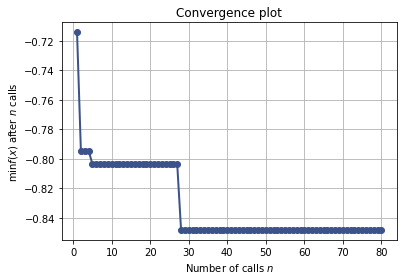

In [22]:
plot_convergence(hp2) 

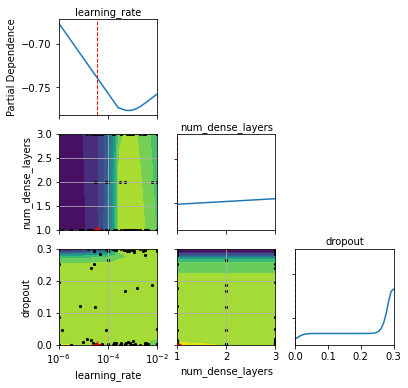

In [30]:
dim_names = ['learning_rate','num_dense_layers','dropout']
fig, ax = plot_objective(result=hp2, dimension_names = dim_names)


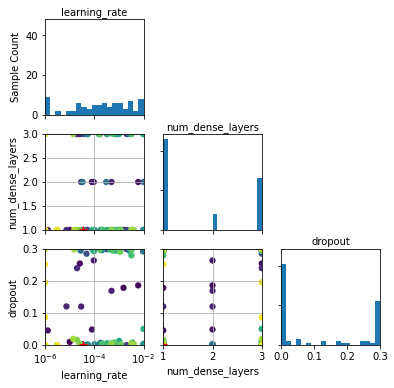

In [36]:
fig, ax = plot_evaluations(result=hp2, dimension_names=dim_names)
plt.savefig(png_dir+'summary_skopt.png')

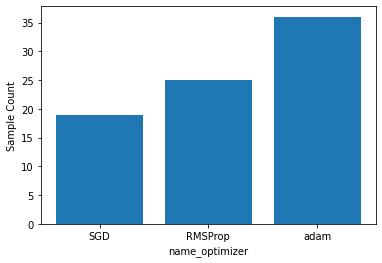

In [40]:
from skopt.plots import plot_histogram
fig, ax = plot_histogram(result=hp2,
                         dimension_name='name_optimizer')

In [33]:
hp2.space.point_to_dict(hp2.x)

{'dropout': 0.0005688001146344714,
 'learning_rate': 3.53084575552001e-05,
 'name_optimizer': 'adam',
 'num_dense_layers': 1}

In [41]:
model = tf.keras.models.load_model(path_best_model)

In [42]:
model.evaluate_generator(validation_generator)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.35997483134269714, 0.8253968358039856]

# Now lets train the best model on the full dataset

In [9]:
batch_size = 16
input_shape = (150,150,3)


# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip = True,
                                   fill_mode='nearest')

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator()



train_generator = train_datagen.flow_from_directory(input_dir+'sep_Images/train_CLAHE/',  # this is the target directory
                                                   target_size=input_shape[:-1],  # all images will be resized to 150x150
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   color_mode='rgb',
                                                   seed= 42)  #useless for the no augmentation 

validation_generator = test_datagen.flow_from_directory(input_dir+'sep_Images/validation_CLAHE/',  # this is the target directory
                                                   target_size=input_shape[:-1],  # all images will be resized to 150x150
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   color_mode='rgb',
                                                   seed= 42)  #useless for the no augmentation 


STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

FileNotFoundError: ignored

In [6]:
os.listdir(input_dir+'sep_Images')

['train', 'validation', 'validation_CLAHE']

In [12]:
final_model = create_model(learning_rate=3.5e-5,num_dense_layers=1,name_optimizer='adam',dropout=0)
final_model.summary()

Model: "my_xception"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Rescaling_layer (Rescaling)  (None, 150, 150, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
FC_layer_1 (Dense)           (None, 512)               26214912  
_________________________________________________________________
Output_layer (Dense)         (None, 4)                 2052      
Total params: 47,078,444
Trainable params: 26,216,964
Non-trainable params: 20,861,480
_________________________________________________________________


In [13]:
history_final = final_model.fit_generator(generator=train_generator,
                                  steps_per_epoch=STEP_SIZE_TRAIN,
                                  validation_data=validation_generator,
                                  validation_steps=STEP_SIZE_VALID,
                                  epochs=100,
                                  callbacks=get_callbacks(patience = 10,save_name=model_dir+'final.h5')
                                  )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
27/30 [==========================>...] - ETA: 8s - loss: 1.6102 - accuracy: 0.4219 

KeyboardInterrupt: ignored